 ## step1p4_mp.ipynb

This is a version of net_sim_mp.ipynb that is specialized for running parallel versions of step 1 part 3 with a different runner specification for each unit model.


By `Sergio Verduzco`  
August 2018

In [1]:
# import the ei_network class and draculab
%cd ..
from ei_network import *
from pathos.multiprocessing import ProcessingPool
import sys

/home/z/projects/draculab


In [2]:
# This is the name of the file where logging will happen
log_file = "./logs/step1p4_mp" + time.strftime("_%m-%d-%y.txt")

In [14]:
%%capture capt 
# logging draculab version used for this session
print('#======================================================')
print('#             | Latest git commit: |')
print('#====================================================== \n#', end=' ')
!git log -1 --oneline --color=never

In [15]:
# Write the output of the cell above in the simulation log
f = open(log_file, mode='a')
f.write(capt.stdout)
f.close()

In [3]:
#~~~~~~~~~~~~ sigmoidal runner specification ~~~~~~~~~~~~

class s1p4_sig_runner():
    """ A class to run several ei_network objects, each in a different process."""
    def __init__(self, pkl_file=None):
        """ Set parameter values and build the networks. 
        
            Args:
                pkl_file : a string with the file name (including path) of the .pkl file from 
                           an object from this class that was previously dilled. The networks from
                           that object are used for initialization. 
        
            Parameters set:
            name : a name that describes how this version of mp_net_runner is being used.
            n_procs : number of processes to use.
            n_nets : number of networks that will be created.
            n_pres : n_pres[i] = number of input presentations for net 'i'
            pres_t : pres_t[i] = duration of each presentation for net 'i'
            inp_pats : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config.
            inp_funcs : inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
            inp_hist1 : inp_hist1[i] = list with ID's of the inputs presented by layer I1 of network 'i'. 
            inp_hist2 : inp_hist2[i] = list with ID's of the inputs presented by layer I2 of network 'i'. 
        """
        self.name = 's1p4mp_sig_test1'  # a name that describes the use
        self.code = '' # to place the source code in the mp_net_runner class (e.g. this cell)
        self.n_procs = 15  # one per network is good
        self.n_nets = 15
        self.n_pres = [200]*self.n_nets # n_pres[i] = number of input presentations for net 'i'
        self.pres_t = [1.]*self.n_nets # pres_t[i] = duration of each presentation for net 'i'
        self.inp_pats = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_funcs = [] # inp_pats[i] = dictionary of input pattern creators for net 'i'. See input_config
        self.inp_hist1 = [[] for _ in range(self.n_nets)]  
        self.inp_hist2 = [[] for _ in range(self.n_nets)] 
        
        if pkl_file:
            # One way to continue simulations. 
            F = open(pkl_file, 'rb')
            dill_obj = dill.load(F)
            self.nets = dill_obj.nets
            self.input_list = dill_obj.input_list
            self.code = dill_obj.code
            F.close()
            del dill_obj 
            for net in self.nets:
                net.annotate("Network reloaded from pkl file.", make_history=True)
            return   
        
        layers = ['L','I1', 'I2', 'I3', 'LI3', 'D', 'upd', 'des']  
        # L is the representatioan layer, I1,2,3 are the source layers, LI3 is the bidirectionally connected input layer,
        # D is the delta unit, upd signals plasticity updates to D, des is the desired output of D.
        # The sharpening unit for L, LI3, and D is in the x population.
        self.nets = [ei_network(layers, net_number=i) for i in range(self.n_nets)]
        
        # Setting the parameter changes for all networks
        ## First, set baseline changes
        for idx, net in enumerate(self.nets):
            net.annotate('This is network ' + str(idx) + ' in a run of an mp_net_runner object called ' + self.name)
            net.annotate('Based on the step1p2_07-19-18.txt, trying to get a baseline configuration for sigmoidals, and')
            net.annotate('for step1p4_mp.')
            #net.annotate('otherwise very good parameters from a simulation logged in step1p2_07/20/18.txt .')
            #net.annotate('10x10 in L.e and 5x5 in L.i without compensating. In here the radius of connection')
            #net.annotate('is increased, the standard tau_scale is decreased, and in the variations to the homeostatic ')
        #----------------------------------
            L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            I3 = net.layers['I3']
            LI3 = net.layers['LI3']
            D = net.layers['D']
            upd = net.layers['upd']
            des = net.layers['des']
        #----------------------------------
            utype_L = unit_types.sigmoidal
            L.annotate('Configuration for %s in L.e' % (utype_L.name))
            L.set_param('e_pars', 'type', utype_L)
            L.set_param('e_pars', 'slope_min', 1.7)
            L.set_param('e_pars', 'slope_wid', .5)
            L.set_param('e_pars', 'thresh_min', 0.)
            L.set_param('e_pars', 'thresh_wid', 0.5)
            L.set_param('e_pars', 'tau_min', 0.1)
            L.set_param('e_pars', 'tau_wid', 0.3)
            L.set_param('e_pars', 'n_ports', 1)
            L.set_param('e_pars', 'branch_params', {'branch_w' : [0.3, 0.7], 'slopes' : 3, 'threshs' : 0.1})
            L.set_param('e_pars', 'tau_slow', 10.)
            L.set_param('e_pars', 'tau_fast', 0.05)
            L.set_param('e_pars', 'c', 3.)
            L.set_param('e_pars', 'tau_scale', .008)
            L.set_param('e_pars', 'tau_relax', 10.)
            L.set_param('e_pars', 'Kp', .02)
            L.set_param('e_pars', 'tau_thr', .01)
            L.set_param('e_pars', 'rdc_port', 0)
            L.set_param('e_pars', 'hr_port', 0)
            L.set_param('e_pars', 'thr_fix', 0.1)
            L.set_param('e_pars', 'tau_fix', 0.1)
            L.set_param('e_pars', 'sharpen_port', 2)
        #----------------------------------
            #L.annotate("Adjusting size of e,i groups, and connection weights.")
            L.set_param('e_geom', 'rows', 10)
            L.set_param('e_geom', 'columns', 10)
            L.set_param('i_geom', 'rows', 5)
            L.set_param('i_geom', 'columns', 5)
            L.set_param('e_geom', 'jitter', 0.)
            L.set_param('i_geom', 'jitter', 0.)
            L.set_param('ee_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ei_conn', 'weights',{'uniform' : {'low': .01, 'high' : 0.3}})
            L.set_param('ie_conn', 'weights',{'uniform' : {'low': -1.2, 'high' : -.2}})
            L.set_param('ii_conn', 'weights',{'uniform' : {'low': -1., 'high' : -0.01}})
        #----------------------------------
            #L.annotate("Setting local inputs for L")
            L.set_param('x_geom', 'rows', 0) # one or zero inputs in L, depending on sharpening
            L.set_param('x_geom', 'columns', 1)
            L.set_param('xe_conn', 'mask', {'circular': {'radius': 100.}}) # projecting to all L.e units
            L.set_param('xe_conn', 'kernel', 1.)
            L.set_param('xe_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            L.set_param('xe_syn', 'inp_ports', L.e_pars['sharpen_port'])
            L.set_param('x_pars', 'tau_fast', 0.05)
        #-----------------------------------
            # specifying local input ports
            L.set_param('ee_syn', 'inp_ports', 0)
            L.set_param('ie_syn', 'inp_ports', 1)
        #----------------------------------
            L.annotate("Using oja input synapses")
            L.set_param('xe_syn', 'type', synapse_types.oja)
            L.set_param('xe_syn', 'lrate', 1./100.)
            L.set_param('xi_syn', 'type', synapse_types.oja)
            L.set_param('xi_syn', 'lrate', 1./100.)
        #----------------------------------
            L.annotate("Using sq_hebbsnorm EE synapses")
            L.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            L.set_param('ee_syn', 'lrate', 1./100.)
            L.set_param('ee_syn', 'omega', 1.5)
        #----------------------------------
            L.annotate("Using corr_homeo_inhib IE synapses")
            L.set_param('ie_syn', 'type', synapse_types.corr_inh)
            L.set_param('ie_syn', 'lrate', 1./40.)
            L.set_param('ie_syn', 'des_act', 0.3)
        #----------------------------------
            L.annotate("Using static EI synapses")
            L.set_param('ei_syn', 'type', synapse_types.static)
        #----------------------------------
            #I1.annotate("Configuration of I1 geometry")
            I1.set_param('e_geom', 'rows', 0)
            I1.set_param('i_geom', 'rows', 0)
            I1.set_param('x_geom', 'rows', 10)
            I1.set_param('x_geom', 'columns', 1)
            I1.set_param('x_geom', 'extent', [.5, 1.])
            I1.set_param('x_geom', 'center', [-.7, 0.])
        #----------------------------------
            #I2.annotate("Configuration of I2 geometry")
            I2.set_param('e_geom', 'rows', 0)
            I2.set_param('i_geom', 'rows', 0)
            I2.set_param('x_geom', 'rows', 1)
            I2.set_param('x_geom', 'columns', 10)
            I2.set_param('x_geom', 'extent', [1., .5])
            I2.set_param('x_geom', 'center', [0., .7])
        #----------------------------------
            #I3.annotate("Configuration of I3 geometry")
            I3.set_param('e_geom', 'rows', 0)
            I3.set_param('i_geom', 'rows', 0)
            I3.set_param('x_geom', 'rows', 1)
            I3.set_param('x_geom', 'columns', 10)
            I3.set_param('x_geom', 'extent', [1., .5])
            I3.set_param('x_geom', 'center', [0., -.9])
        #----------------------------------
            L.set_param('n', 'w_track', 16)
            LI3.set_param('n', 'w_track', 8)
            I1.set_param('n', 'w_track', 0)
            I2.set_param('n', 'w_track', 0)
            I3.set_param('n', 'w_track', 0)
        #----------------------------------
        # Layer LI3 parameters
        #----------------------------------
            utype_LI3 = unit_types.sig_trdc
            LI3.annotate("Configuration for %s units in layer LI3." %(utype_LI3.name))
            LI3.set_param('e_pars', 'type', utype_LI3)
            LI3.set_param('e_pars', 'slope_min', 1.9)
            LI3.set_param('e_pars', 'slope_wid', .2)
            LI3.set_param('e_pars', 'thresh_min', 0.2)
            LI3.set_param('e_pars', 'thresh_wid', 0.5)
            LI3.set_param('e_pars', 'tau_min', 0.1)
            LI3.set_param('e_pars', 'tau_wid', 0.3)
            LI3.set_param('e_pars', 'n_ports', 2)
            LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.3, 0.7], 'slopes' : 3, 'threshs' : 0.1})
            LI3.set_param('e_pars', 'tau_slow', 10.)
            LI3.set_param('e_pars', 'tau_fast', 0.05)
            LI3.set_param('e_pars', 'c', 2.)
            LI3.set_param('e_pars', 'tau_scale', .05)
            LI3.set_param('e_pars', 'tau_relax', 10.)
            LI3.set_param('e_pars', 'Kp', .02)
            LI3.set_param('e_pars', 'tau_thr', .01)
            LI3.set_param('e_pars', 'rdc_port', 0)
            LI3.set_param('e_pars', 'hr_port', 0)
            LI3.set_param('e_pars', 'thr_fix', 0.1)
            LI3.set_param('e_pars', 'tau_fix', 0.1)
            LI3.set_param('e_pars', 'sharpen_port', 2)
        #----------------------------------
            #LI3.annotate("Adjusting e,i groups, and configuring EI,IE connections")
            LI3.set_param('e_geom', 'rows', 1)
            LI3.set_param('e_geom', 'columns', 10)
            LI3.set_param('i_geom', 'rows', 1)
            LI3.set_param('i_geom', 'columns', 5)
            LI3.set_param('e_geom', 'jitter', 0.)
            LI3.set_param('i_geom', 'jitter', 0.)
            LI3.set_param('e_geom', 'extent', [1., .5])
            LI3.set_param('e_geom', 'center', [0., -.7])
            LI3.set_param('i_geom', 'extent', [1., .5])
            LI3.set_param('i_geom', 'center', [0., -.7])
            LI3.set_param('x_geom', 'extent', [1., .5])
            LI3.set_param('x_geom', 'center', [0., -.7])

            LI3.set_param('ee_conn', 'mask', {'circular' : {'radius': 3.}})
            LI3.set_param('ee_conn', 'kernel', {'gaussian' : {'p_center' : 1.1, 'sigma' : .5}})
            LI3.set_param('ee_conn', 'allow_autapses', True)
            LI3.set_param('ee_conn', 'weights', {'gaussian' : {'w_center' : .5, 'sigma' : .2}})

            LI3.set_param('ei_conn', 'mask', {'annular' : {'inner_radius': .2, 'outer_radius' : 0.5}})
            LI3.set_param('ei_conn', 'kernel', 1.)
            LI3.set_param('ei_conn', 'weights',{'ring_gaussian' : {'w_center' : .6, 'sigma' : .2, 'radius' : .3}})

            LI3.set_param('ie_conn', 'mask', {'circular' : {'radius': 3.}})
            LI3.set_param('ie_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : 2.}})
            LI3.set_param('ie_conn', 'allow_autapses', True)
            LI3.set_param('ie_conn', 'weights', {'gaussian' : {'w_center' : -.8, 'sigma' : .5}})

            LI3.set_param('ii_conn', 'weights',{'uniform' : {'low': -.5, 'high' : -0.2}})
        #----------------------------------
            #LI3.annotate("Setting LI3.x configuration")
            LI3.set_param('x_geom', 'rows', 0) # one or zero inputs in L, depending on sharpening
            LI3.set_param('x_geom', 'columns', 0)
            LI3.set_param('xe_conn', 'mask', {'circular': {'radius': 100.}}) # projecting to all LI3.e units
            LI3.set_param('xe_conn', 'kernel', 1.)
            LI3.set_param('xe_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            LI3.set_param('xe_syn', 'inp_ports', L.e_pars['sharpen_port'])
        #-----------------------------------
        # specifying local input ports
            LI3.set_param('ee_syn', 'inp_ports', 0)
            LI3.set_param('ie_syn', 'inp_ports', 1)
        #----------------------------------
            LI3.annotate("Using static input synapses")
            LI3.set_param('xe_syn', 'type', synapse_types.static)
            LI3.set_param('xi_syn', 'type', synapse_types.static)
        #----------------------------------
            LI3.annotate("Using sq_hebbsnorm EE synapses")
            LI3.set_param('ee_syn', 'type', synapse_types.sq_hebbsnorm)
            LI3.set_param('ee_syn', 'lrate', 1./100.)
            LI3.set_param('ee_syn', 'omega', 1.5)
        #----------------------------------
            LI3.annotate("Using static IE synapses")
            LI3.set_param('ie_syn', 'type', synapse_types.static)
        #----------------------------------
            LI3.annotate("Using anticov EI synapses")
            LI3.set_param('ei_syn', 'type', synapse_types.anticov)
            LI3.set_param('ei_syn', 'lrate', 1./500.)
        #----------------------------------
        # Delta unit parameters
        #----------------------------------
            utype_D = unit_types.delta_linear
            D.set_param('e_pars', 'type', utype_D)
            D.set_param('e_pars', 'n_ports', 3)
            D.set_param('e_pars', 'tau_slow', 10.)
            D.set_param('e_pars', 'tau_fast', 0.02)
            D.set_param('e_pars', 'gain', 1.)
            D.set_param('e_pars', 'tau_e', .7) # gives roughly 0.5 seconds
            D.set_param('e_pars', 'bias_lrate', .0001)
        #----------------------------------
            #D.annotate("Adjusting size of e,i groups.")
            D.set_param('e_geom', 'rows', 1)
            D.set_param('e_geom', 'columns', 1)
            D.set_param('i_geom', 'rows', 0)
            D.set_param('ee_conn', 'weights',{'uniform' : {'low': 0., 'high' : 0.}})
            D.set_param('ee_conn', 'allow_autapses', False)
        #----------------------------------
            #D.annotate("Setting input parameters")
            D.set_param('x_geom', 'rows', 0) 
            D.set_param('x_geom', 'columns', 0) 
        #----------------------------------
            #upd.annotate("Leaving a single input unit in the upd layer")
            upd.set_param('e_geom', 'rows', 0)
            upd.set_param('i_geom', 'rows', 0)
            upd.set_param('x_geom', 'rows', 1)
            upd.set_param('x_geom', 'columns', 1)
        #----------------------------------
            #upd.annotate("Configuring upd unit")
            upd.set_param('x_pars', 'function', lambda x : None)
            upd.set_param('x_pars', 'init_val', 1.)
            upd.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
            des.annotate("Leaving a single input unit in the des layer")
            des.set_param('e_geom', 'rows', 0)
            des.set_param('i_geom', 'rows', 0)
            des.set_param('x_geom', 'rows', 1)
            des.set_param('x_geom', 'columns', 1)
        #----------------------------------
            #des.annotate("Configuring des unit")
            des.set_param('x_pars', 'function', lambda x : None)
            des.set_param('x_pars', 'init_val', 1.)
            des.set_param('x_pars', 'coordinates', np.array([0.,0.]))
        #----------------------------------
            D.set_param('n', 'w_track', 0)
            upd.set_param('n', 'w_track', 0)
            des.set_param('n', 'w_track', 0)
        #----------------------------------
        # Add interlayer connections
            net.add_connection(('I1','x'), ('L','e'))
            net.add_connection(('I1','x'), ('L','i'))
            net.add_connection(('I2','x'), ('L','e'))
            net.add_connection(('I2','x'), ('L','i'))
            net.add_connection(('I3','x'), ('LI3','e'))
            net.add_connection(('I3','x'), ('LI3','i'))
            net.add_connection(('LI3','e'), ('L','e'))
            net.add_connection(('LI3','e'), ('L','i'))
            net.add_connection(('L','e'), ('LI3','e'))
            net.add_connection(('L','e'), ('D', 'e'))
            net.add_connection(('upd','x'), ('D','e'))
            net.add_connection(('des','x'), ('D','e'))
        #----------------------------------        
        # Configure interlayer connections
            net.set_param('I1x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Le_conn', 'number_of_connections', 2)
            net.set_param('I1x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I1x_Le_conn', 'dist_dim', 'y')
            net.set_param('I1x_Le_conn', 'edge_wrap', True)
            net.set_param('I1x_Le_syn', 'inp_ports', 0)
            net.set_param('I1x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I1x_Le_syn', 'lrate', 1./50.)
            net.set_param('I1x_Le_syn', 'omega', 1.5)

            net.set_param('I1x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I1x_Li_conn', 'number_of_connections', 2)
            net.set_param('I1x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I1x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I1x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I1x_Li_conn', 'dist_dim', 'y')
            net.set_param('I1x_Li_conn', 'edge_wrap', True)

            net.set_param('I2x_Le_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Le_conn', 'number_of_connections', 2)
            net.set_param('I2x_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Le_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('I2x_Le_conn', 'dist_dim', 'x')
            net.set_param('I2x_Le_conn', 'edge_wrap', True)
            net.set_param('I2x_Le_syn', 'inp_ports', 0)
            net.set_param('I2x_Le_syn', 'type', synapse_types.bcm)
            net.set_param('I2x_Le_syn', 'lrate', 1./50.)
            net.set_param('I2x_Le_syn', 'omega', 1.5)

            net.set_param('I2x_Li_conn', 'connection_type', 'convergent')
            net.set_param('I2x_Li_conn', 'number_of_connections', 2)
            net.set_param('I2x_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('I2x_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('I2x_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : 0.5}})
            net.set_param('I2x_Li_conn', 'dist_dim', 'x')
            net.set_param('I2x_Li_conn', 'edge_wrap', True)

            net.set_param('I3x_LI3e_conn', 'mask', {'circular': {'radius': .2}})
            net.set_param('I3x_LI3e_conn', 'kernel', 1.)
            net.set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 2., 'sigma' : .2}})
            net.set_param('I3x_LI3e_conn', 'dist_dim', 'x')
            net.set_param('I3x_LI3e_conn', 'edge_wrap', True)
            net.set_param('I3x_LI3e_syn', 'inp_ports', 1)
            net.set_param('I3x_LI3e_syn', 'type', synapse_types.static)

            net.set_param('I3x_LI3i_conn', 'mask', {'annular' : {'inner_radius': .1, 'outer_radius' : 0.5}})
            net.set_param('I3x_LI3i_conn', 'kernel', 1.)
            net.set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .6, 'sigma' : .3, 'radius' : .2}})
            net.set_param('I3x_LI3i_conn', 'dist_dim', 'x')
            net.set_param('I3x_LI3i_conn', 'edge_wrap', True)

            net.set_param('LI3e_Le_conn', 'connection_type', 'convergent')
            net.set_param('LI3e_Le_conn', 'number_of_connections', 2)
            net.set_param('LI3e_Le_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('LI3e_Le_conn', 'kernel', .4)
            net.set_param('LI3e_Le_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .9}})
            net.set_param('LI3e_Le_conn', 'edge_wrap', True)
            net.set_param('LI3e_Le_syn', 'inp_ports', 0)
            net.set_param('LI3e_Le_syn', 'type', synapse_types.bcm)
            net.set_param('LI3e_Le_syn', 'lrate', 1./50.)
            net.set_param('LI3e_Le_syn', 'omega', 1.5)

            net.set_param('LI3e_Li_conn', 'connection_type', 'convergent')
            net.set_param('LI3e_Li_conn', 'number_of_connections', 2)
            net.set_param('LI3e_Li_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('LI3e_Li_conn', 'kernel', {'linear' : {'c': 1., 'a': 0.5}})
            net.set_param('LI3e_Li_conn', 'weights', {'uniform' : {'low' : 0.2, 'high' : .5}})
            net.set_param('LI3e_Li_conn', 'dist_dim', 'x')
            net.set_param('LI3e_Li_conn', 'edge_wrap', True)

            net.set_param('Le_LI3e_conn', 'connection_type', 'divergent')
            net.set_param('Le_LI3e_conn', 'number_of_connections', 6)
            net.set_param('Le_LI3e_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('Le_LI3e_conn', 'kernel', 1.)
            net.set_param('Le_LI3e_conn', 'weights', {'uniform' : {'low' : 0.01, 'high' : .02}})
            net.set_param('Le_LI3e_conn', 'edge_wrap', True)
            net.set_param('Le_LI3e_conn', 'boundary', {'center':L.e_geom['center'], 'extent':L.e_geom['extent']})
            net.set_param('Le_LI3e_syn', 'inp_ports', 1)
            net.set_param('Le_LI3e_syn', 'type', synapse_types.sq_hebbsnorm)
            net.set_param('Le_LI3e_syn', 'lrate', 1./50.)
            net.set_param('Le_LI3e_syn', 'omega', 1.) # for sq_hebbsnorm
            
            net.set_param('Le_De_conn', 'connection_type', 'divergent')
            net.set_param('Le_De_conn', 'mask', {'circular': {'radius': 5.}})
            net.set_param('Le_De_conn', 'kernel', 1.)
            net.set_param('Le_De_conn', 'weights', {'uniform' : {'low' : 0.01, 'high' : .05}})
            net.set_param('Le_De_syn', 'inp_ports', 0)
            net.set_param('Le_De_syn', 'type', synapse_types.delta)
            net.set_param('Le_De_syn', 'lrate', .1)

            net.set_param('updx_De_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('updx_De_conn', 'kernel', 1.)
            net.set_param('updx_De_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            net.set_param('updx_De_syn', 'inp_ports', 2)

            net.set_param('desx_De_conn', 'mask',{'circular': {'radius': 10.}})
            net.set_param('desx_De_conn', 'kernel', 1.)
            net.set_param('desx_De_conn', 'weights', {'uniform' : {'low': 1., 'high': 1.}})
            net.set_param('desx_De_syn', 'inp_ports', 1)
          
        # Now adjust networks individually
        ### network 0 is the baseline
        ### network 1
        n = 1
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using ds LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.double_sigma)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', -0.1)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.3, 0.4, 0.3], 'slopes' : 3, 'threshs' : 0.})
        LI3.set_param('ie_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : 1.8}})
        LI3.set_param('ie_conn', 'weights', {'gaussian' : {'w_center' : -.9, 'sigma' : .6}})
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)    
        ### network 2
        n = 2
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sigma_double_sigma)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'omega', 1.5) # for sq_hebbsnorm
        ### network 3
        n = 3
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_trdc LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_trdc)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1)  # only difference with n=2
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        ### Network 4
        n = 4
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_sharp LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_sharp)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1) 
        LI3.set_param('e_pars', 'thr_fix', 0.)
        LI3.set_param('ee_syn', 'inp_ports', 1) 
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        LI3.set_param('e_pars', 'sharpen_port', 3) # beware of forgetting this
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port'])
        LI3.set_param('x_pars', 'tau_fast', 0.05)
        ### Network 5
        n = 5
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using double_sigma_n LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.double_sigma_n)
        LI3.set_param('e_pars', 'slope_min', 13)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.1)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.1, 0.6, .3], 'slopes' : 4, 'threshs' : 0.2})
        LI3.set_param('e_pars', 'phi', 0.4)
        LI3.set_param('ie_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : 1.8}})
        LI3.set_param('ie_syn', 'inp_ports', 0)
        LI3.set_param('ee_syn', 'omega', 1.8)
        #self.nets[n].set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .4, 'sigma' : .3, 'radius' : .2}})
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        ### Network 6
        n = 6
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_n LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_n)  # same parameters as sds...
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        #self.nets[n].set_param('I3x_LI3i_conn', 'weights', {'ring_gaussian' : {'w_center' : .4, 'sigma' : .3, 'radius' : .2}})
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'omega', 1.5) # for sq_hebbsnorm
        ### Network 7
        n = 7
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_n_sharp LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.sds_n_sharp)  # same parameters as sds_sharp
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1) 
        LI3.set_param('e_pars', 'thr_fix', 0.)
        LI3.set_param('ee_syn', 'inp_ports', 1) 
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        LI3.set_param('e_pars', 'sharpen_port', 3) # beware of forgetting this
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port'])
        LI3.set_param('x_pars', 'tau_fast', 0.05)
        ### Network 8
        n = 8
        LI3 = self.nets[n].layers['LI3'] 
        LI3.annotate(">>> Using ds_ssrdc_sharp LI3 units")
        LI3.set_param('e_pars', 'type', unit_types.ds_ssrdc_sharp)
        LI3.set_param('e_pars', 'slope_min', 6)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.1)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.2, 0.5, .3], 'slopes' : 4, 'threshs' : 0.})
        LI3.set_param('e_pars', 'tau_scale', .05)
        LI3.set_param('e_pars', 'tau_relax', 5.)
        LI3.set_param('e_pars', 'Kp', .02)
        LI3.set_param('e_pars', 'rdc_port', 0)
        LI3.set_param('e_pars', 'sharpen_port', 3)
        LI3.set_param('ie_syn', 'inp_ports', 1)
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port'])
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 2., 'sigma' : .1}})
        LI3.set_param('ie_syn', 'inp_ports', 1) # sneaky, effective, inhibition goes to strong branch
        ### network 9
        n = 9
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.sigma_double_sigma)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        ### network 10
        n = 10
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_trdc LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.sds_trdc)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1)  # only difference with n=2
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        ### Network 11
        n = 11
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_sharp LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.sds_sharp)
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1) 
        LI3.set_param('e_pars', 'thr_fix', 0.)
        LI3.set_param('e_pars', 'sharpen_port', 3)
        LI3.set_param('ee_syn', 'inp_ports', 1) 
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port']) # don't forget to set sharpen port
        LI3.set_param('x_pars', 'tau_fast', 0.05)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        ### Network 12
        n = 12
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using double_sigma_n LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.double_sigma_n)
        LI3.set_param('e_pars', 'slope_min', 13)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.1)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.1, 0.6, .3], 'slopes' : 4, 'threshs' : 0.2})
        LI3.set_param('e_pars', 'phi', 0.4)
        LI3.set_param('ie_conn', 'kernel', {'gaussian' : {'p_center' : 1., 'sigma' : 1.8}})
        LI3.set_param('ie_syn', 'inp_ports', 0)
        LI3.set_param('ee_syn', 'omega', 1.8)
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        ### Network 13
        n = 13
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_n LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.sds_n)  # same parameters as sds...
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 3)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('ee_syn', 'inp_ports', 1)  # This is the key
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  # This is the key
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        ### Network 14
        n = 14
        LI3= self.nets[n].layers['LI3']
        LI3.annotate(">>> Using sds_n_sharp LI3 units and oja L-LI3 synapses")
        LI3.set_param('e_pars', 'type', unit_types.sds_n_sharp)  # same parameters as sds_sharp
        LI3.set_param('e_pars', 'slope_min', 8)
        LI3.set_param('e_pars', 'slope_wid', .5)
        LI3.set_param('e_pars', 'thresh_min', 0.)
        LI3.set_param('e_pars', 'thresh_wid', 0.2)
        LI3.set_param('e_pars', 'n_ports', 4)
        LI3.set_param('e_pars', 'branch_params', {'branch_w' : [0.4, 0.6], 'slopes' : 4, 'threshs' : 0.3})
        LI3.set_param('e_pars', 'rdc_port', 1) 
        LI3.set_param('e_pars', 'thr_fix', 0.)
        LI3.set_param('e_pars', 'sharpen_port', 3)
        LI3.set_param('ee_syn', 'inp_ports', 1) 
        LI3.set_param('ee_syn', 'omega', .5)
        LI3.annotate("Using corr_inh IE synapses")
        LI3.set_param('ie_syn', 'type', synapse_types.corr_inh)
        LI3.set_param('ie_syn', 'lrate', 1./20.)
        LI3.set_param('ie_syn', 'des_act', 0.3)
        LI3.set_param('ie_syn', 'inp_ports', 0)
        self.nets[n].set_param('I3x_LI3e_conn', 'weights', {'gaussian' : {'w_center' : 1.5, 'sigma' : .1}})
        self.nets[n].set_param('I3x_LI3e_syn', 'inp_ports', 0)  
        self.nets[n].set_param('Le_LI3e_syn', 'inp_ports', 2)
        LI3.set_param('x_geom', 'rows', 1) # one input in LI3
        LI3.set_param('x_geom', 'columns', 1)
        LI3.set_param('xe_syn', 'inp_ports', LI3.e_pars['sharpen_port']) # don't forget to set sharpen port
        LI3.set_param('x_pars', 'tau_fast', 0.05)
        self.nets[n].set_param('Le_LI3e_syn', 'type', synapse_types.oja)
        
        self.build()
                              
    def build(self):
        # Building the networks
        # The point of putting this outside the __init__ method is that if at some point the networks get too
        # big and take a long time to build, you can build them in parallel by creating a build(net_num)
        # method and then calling it from run_all with pool.map(build, range(self.n_nets))
        for net in self.nets:
            net.build()
         
    def inp_pat1(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for I1. """
        if random:  
            idx = self.input_list[pres][0] # a list of randomly permuted inputs, from input_config
        else:
            idx = int( np.floor( (pres%(n_pat1*n_pat2)/n_pat2) )  )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)

    def inp_pat2(self, pres, n_pat1, n_pat2, random=True):
        """ A function to create input patterns for I2. """
        if random:  
            idx = self.input_list[pres][1]
        else:
            mpres = pres%(n_pat1*n_pat2)
            idx = int( np.round( ( mpres % n_pat2) )  )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)
    
    def I3_fun(self, I1, I2, n_pat3):
        """ The function that produces the I3 input pattern from the I1 and I2 input patterns. """
        return (I1 + I2)%n_pat3
    
    def inp_pat3(self, pres, n_pat1, n_pat2, n_pat3, random=True):
        """ A function to create input patterns for I3. """
        if random:  
            idx = self.input_list[pres][2]
        else:
            mpres = pres%(n_pat1*n_pat2)
            idx = int( self.I3_fun(np.round(mpres % n_pat2), np.floor(mpres / n_pat2), n_pat3) )
        return ([0.5*(1. + np.cos(2.*np.pi*(x - idx)/n_pat1)) for x in range(n_pat1)], idx)

    def make_I1_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat1 suited of the 'net_id' net. """
        return lambda pres, rows, columns, n_id: self.inp_pat1(pres, n_pat1, n_pat2, random=rnd) 
    
    def make_I2_inp(self, n_pat1, n_pat2, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat2 suited of the 'net_id' net. """
        return lambda pres, rows, columns, n_id: self.inp_pat2(pres, n_pat1, n_pat2, random=rnd) 
    
    def make_I3_inp(self, n_pat1, n_pat2, n_pat3, net_id, rnd):
        """ Returns a function that is a specific version of self.inp_pat3 suited of the 'net_id' net. """
        return lambda pres, rows, columns, n_id: self.inp_pat3(pres, n_pat1, n_pat2, n_pat3, random=rnd) 

    def make_shrp_fun(self, prev_pat, cur_pat, init_time, pres_time):
        """ Returns a function that goes from 1 to 0 when its argument is close to init_time or init_time+pres_time.
            
            Args:
                prev_pat : 1-D numpy array with the previous input pattern. (not currently used)
                cur_pat : 1-D numpy array with the current input pattern. (not currently used)
                init_time: initial time of this presentation.
                pres_time: duration of this presentation.
        """
        eps = .1 # distance to the input change where sharpening is released
        return lambda t : 0. if (t < init_time+eps or t > init_time+pres_time-eps) else 1.
    
    def set_shrp_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the sharpening function on the given input units using make_shrp_fun. """
        for unit in inp_units:
            unit.set_function( self.make_shrp_fun(pre_inp, cur_inp, init_time, pres_time) )

    def make_upd_fun(self, prev_pat, cur_pat, init_time, pres_time, inp_units):
        """ Returns the function for update inputs to delta units. """
        eps = .5 # update is started eps units before the next input
        return lambda t : 1. if (t > init_time+pres_time-eps and t < init_time+pres_time-eps/2.) else 0.
        #return lambda t: 1.  # constantly updating unit

    def set_upd_fun(self, pre_inp, cur_inp, init_time, pres_time, inp_units):
        """ Sets the update functions on the given inp_units. """
        for unit in inp_units:
            unit.set_function( self.make_upd_fun(pre_inp, cur_inp, init_time, pres_time, inp_units) )
            
    def des_pat(self, pres, n_inp):
        """ The function that creates the desired pattern for delta units. Currently follows inp_pat3. """
        #p = pres%n_inp
        idx = self.input_list[pres][2]
        return ([0.1 * idx], idx)
    
    def make_des_pat(self, n_inp):
        """ Uses des_pat() to create a target function. """
        return lambda pres, rows, columns, n_id: self.des_pat(pres, n_inp)

    def input_config(self):
        """ Populates the self.inp_pats, and self.inp_funcs lists used by run_net() to provide inputs.
        
            inp_pats[i] is the set_inp_pat dictionary given as an argument to ei_network.run for the i-th network.
            inp_funcs[i] is the set_inp_fun dictionary given as an argument to ei_network.run for the i-th network.
        """  
        # Generate input pattern list for I layers
        if not hasattr(self, 'input_list'):
            self.input_list = [] # will contain 3-tuples with all the input indexes (I1x,I2x,I3x)        
        nprs = max(self.n_pres) # how many input patterns to generate
        np1 = self.nets[0].layers['I1'].n['x'] # assuming all networks have same input geometry!!!
        np2 = self.nets[0].layers['I2'].n['x']
        np3 = self.nets[0].layers['I3'].n['x']
        n_inp = np1*np2
        for epoch in range(int(np.floor(nprs/n_inp))): # we present all patterns in one full epoch
            aux_list = []
            for p1 in range(np1):
                for p2 in range(np2):
                    aux_list.append( (p1, p2, self.I3_fun(p1,p2,np3)) ) 
            np.random.shuffle(aux_list)
            self.input_list += aux_list
        rem_inps = int(np.round(nprs%n_inp)) # inputs constituting just part of an epoch
        pat_ids = np.random.choice(range(n_inp), rem_inps, replace=False)
        for pid in pat_ids:
            p1 = int(np.floor(pid/np2))
            p2 = int(round(pid%np2))
            self.input_list.append( ( p1, p2, self.I3_fun(p1,p2,np3) ) ) 
        # Create input pattern dictionaries and append them to the lists
        for idx, net in enumerate(self.nets):
            #L = net.layers['L']
            I1 = net.layers['I1']
            I2 = net.layers['I2']
            I3 = net.layers['I3']
            n_pat1 = I1.n['x']  # number of input patterns for I1 is number of input units
            n_pat2 = I2.n['x']  # number of input patterns for I2 is number of input units     
            n_pat3 = I3.n['x']  # number of input patterns for I3 is number of input units     
            shrp_inp_pat = lambda p, r, c, n : (1., 1)
            upd_inp_pat = lambda p, r, c, n : (1., 1)
            inp_pat_dic = { 'I1' : self.make_I1_inp(n_pat1, n_pat2, idx, True), 
                            'I2' : self.make_I2_inp(n_pat1, n_pat2, idx, True), 
                            'I3' : self.make_I3_inp(n_pat1, n_pat2, n_pat3, idx, True),
                            'L' : shrp_inp_pat,
                            'LI3' : shrp_inp_pat,
                            'upd' : upd_inp_pat,
                            'des' : self.make_des_pat(n_inp) }
            inp_fun_dic = {'L' : self.set_shrp_fun,
                           'LI3' : self.set_shrp_fun,
                           'upd' : self.set_upd_fun }
            self.inp_pats.append(inp_pat_dic)
            self.inp_funcs.append(inp_fun_dic)

    def nullify_I3(self):
        """ Nullifies the I3-LI3 connections in all networks. """
        for net in self.nets:
            net.annotate("Nullifying I3-LI3 connections")
            for syn_list in [net.net.syns[idx] for idx in net.layers['LI3'].e]:
                for syn in syn_list:
                    if syn.preID in net.layers['I3'].x:
                        syn.w = 0.
                        
    def run_net(self, arg):
        net_num = arg[0]
        n_pres = arg[1]
        if n_pres > 0:
            print('Running network %d' % (net_num))
            return self.nets[net_num].run(n_pres, self.pres_t[net_num], self.inp_pats[net_num], self.inp_funcs[net_num])
        else: 
            return self.nets[net_num]
        
    def run_all(self, save=False, log=False, save_interv=10, pool=None):
        sys.setrecursionlimit(5000)  # otherwise the networks can't be pickled
        if pool == None:
            pool = ProcessingPool(nodes=self.n_procs) 
        self.input_config()  # configures the input functions
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        if save:
            run_sched = [ [] for _ in range(self.n_nets) ] # run_sched[i][j] = number of presentations in the j-th run
                                                           # of network i
            for idx in range(self.n_nets):
                base = int(np.floor(self.n_pres[idx]/save_interv))
                run_sched[idx] = [save_interv]*base 
                remainder = self.n_pres[idx]%save_interv
                if remainder > 0:
                    run_sched[idx].append(remainder)
            self.max_runs = max([len(sch) for sch in run_sched])
            run_sched = [sch + [0]*(self.max_runs-len(sch)) for sch in run_sched]
                    
            for run in range(self.max_runs):
                args = [(n, run_sched[n][run]) for n in range(self.n_nets)]
                self.nets = pool.map(self.run_net, args)
                for net in self.nets:
                    net.history.append('ei_network backup after run ' + str(run) + ' of mp_net_runner object ' + self.name)
                print("<><><><><> Backing up simulation after run " + str(run))
                F = open(self.name+'.pkl', 'wb')
                dill.dump(self, F)
                F.close()
        else:
            args = [(n, self.n_pres[n]) for n in range(n_nets)]
            self.nets = pool.map(self.run_net, args)
                
        print('****** Processing finished after %s seconds ******' % (time.time() - start_time)) 
        pool.close()
        pool.join()
        
        if log:
            self.log()
                
    def log(self, file_name=log_file):
        for net in self.nets:
            net.log(file_name, params=(net.net_number == 0))                                                                
            
    def io_compare(self, net_num=0, make_history=False):
        """ Simple analysis of the relation between inputs and outputs.
        
            Let's say input A produces a pattern A* in layer L, and input B produces a pattern B* in L.
            The idea is that if A resembles B, then A* should resemble B*. More generally, some sort of
            distance between A and B should be mapped to A* and B*. One option for the distance is the
            normalized dot product.
            
            This function finds the normalized dot products for all possible values of A and B, and 
            compares these dots products with the corresponding product of A* and B*.
            
            Moreover, it produces plots of:
                * Magnitude of input dot products VS magnitude of output dot products,
                * the mean activity in layer L for each input type,
                * magnitude of dot product for all pairs of inputs,
                * magnitude of dot product for all pairs of outputs,
                * activity in layer L in response to each presentation.
        """
        net = self.nets[net_num]
        pats1 = net.inp_hist['I1']
        pats2 = net.inp_hist['I2']
        n_pat1 = net.layers['I1'].n['x']
        n_pat2 = net.layers['I2'].n['x']
        n_pats = n_pat1*n_pat2
        pres_time = self.pres_t[net_num]
        n_pres = self.nets[net_num].present
        L = net.layers['L']
        inp_pat1 = self.make_I1_inp(n_pat1, n_pat2, net_num, False)
        inp_pat2 = self.make_I2_inp(n_pat1, n_pat2, net_num, False)

        ## For each input presentation obtain the activity vector from layer L (e_pats)
        ppat = int(round(pres_time/net.net_params['min_delay'])) # number of data points per input pattern
        pt = int(round((pres_time-0.2)/net.net_params['min_delay'])) # data point where the vector will come from
        e_pats = np.zeros((len(L.e), n_pres))  # array where we'll store the activity vectors
        for pres in range(n_pres):
            for e_idx, idx in enumerate(L.e):
                e_pats[e_idx, pres] = net.all_activs[idx, pres*ppat + pt]

        ## Obtain the ID of the pattern that appeared at each input presentation (pres_pat)
        pres_pat = [ i[0]*n_pat2 + i[1] for i in self.input_list ]
        
        ## get the mean of output patterns corresponding to the same inputs (mean_out)
        mean_out = np.zeros((len(L.e),n_pats)) # mean_out[:,n] = mean output for input n
        pat_reps = np.zeros(n_pats) # pat_reps[n] = number of times the pattern with ID 'n' appeared
        for pres in range(n_pres):
            mean_out[:, int(pres_pat[pres])] += e_pats[:,pres]
            pat_reps[pres_pat[pres]] += 1
        for pat in range(n_pats):
            if pat_reps[pat] > 1:
                mean_out[:, pat] = mean_out[:, pat] / pat_reps[pat]
        
        ## Obtain the dot products between any two pairs of input (inp_dots) or output (out_dots) patterns
        # get all input patterns
        all_inps = np.zeros((n_pats, n_pat1+n_pat2)) # all_inps[n,:] = input pattern with ID 'n'
        for p1 in range(n_pat1):
            for p2 in range(n_pat2):
                idx = p1*n_pat2+p2
                (all_inps[idx, :n_pat1], _) = inp_pat1(idx, 1, 1, net_num)
                (all_inps[idx, n_pat1:], _) = inp_pat2(idx, 1, 1, net_num)     
        # get matrices with dot products between pairs of patterns
        inp_norm = np.linalg.norm(all_inps[0,:])   # all input vectors have the same norm
        inp_norm2 = inp_norm*inp_norm
        inp_dots = np.zeros((n_pats, n_pats))
        out_dots = np.zeros((n_pats, n_pats))
        for p1 in range(n_pats):
            for p2 in range(n_pats):
                inp_dots[p1,p2] = np.dot(all_inps[p1,:], all_inps[p2,:])/inp_norm2
                if pat_reps[p1] > 0 and pat_reps[p2] > 0: # if the two input patterns were presented
                    vec1 = mean_out[:,p1]
                    vec2 = mean_out[:,p2]
                    norm1 = np.linalg.norm(vec1)
                    norm2 = np.linalg.norm(vec2)
                    out_dots[p1,p2] = np.dot(vec1,vec2)/(norm1*norm2)
                
        # compare the angles between input patterns with the angles between output patterns
        absissae = []
        ordinates = []
        for row in range(n_pats):
            for column in range(n_pats):
                if out_dots[row,column] > 0:
                    absissae.append(inp_dots[row,column])
                    ordinates.append(out_dots[row,column])
            
        #plot the results of the analysis
        %matplotlib inline
        fig, axes = plt.subplots(2,2, figsize=(21, 23))
        fig.subplots_adjust(hspace=0.2, wspace=0.1)

        im0 = axes[0,0].plot(absissae, ordinates, '.')
        axes[0,0].set_title('inp_dots vs out_dots')
        im1 = axes[0,1].imshow(mean_out)
        axes[0,1].set_title('mean output for each input pattern')
        axes[0,1].set_xlabel('input ID')
        fig.colorbar(im1,ax=axes[0,1],fraction=0.1,shrink=0.8)
        im2 = axes[1,0].imshow(inp_dots)
        axes[1,0].set_title('dot products between input vectors')
        im3 = axes[1,1].imshow(out_dots)
        axes[1,1].set_title('dot products between mean output vectors')
        #fig.colorbar(im3,fraction=0.1,shrink=0.8)

        # plot the array of activity patterns
        ex_fig = plt.figure(figsize=(20,10))
        plt.imshow(e_pats)
        
        # A numerical measure of how much the output representation differentiates the inputs may be the norm of (inp_dots - out_dots)
        out_str = "norm of output matrix: %f" % (np.linalg.norm(out_dots))
        inp_str = "norm of input matrix: %f" % (np.linalg.norm(inp_dots))
        diff_norm = np.linalg.norm(inp_dots-out_dots) # will use Frobenius norm, as if they were vectors
        diff_str = "norm of difference between matrices: %f" % (diff_norm)
        print("    " + out_str)
        print("    " + inp_str)
        print("    " + diff_str)
        
        if make_history:
            self.nets[net_num].history.append("io_compare(" + str(net_num)+")")
            self.nets[net_num].history.append(out_str)
            self.nets[net_num].history.append(inp_str)
            self.nets[net_num].history.append(diff_str)
        
    def I3_LI3_compare(self, start_time, jump, net_num=0, make_history=False):
        """ Compare the activities of I3 and LI3 from start_time onwards. 
            
            LI3 is supposed to learn the function that defines I3 output given I1 and I2. To test if this happens,
            first run the network normally for a long enough period, then run nullify_I3, and then run it a little
            longer. Once that is done, you can use I3_LI3_compare to see whether LI3 resembles LI3 even after the
            I3->LI3 connections are removed.
            
            Args:
                start_time: time when the comparison starts.
                jump: only one out of every 'jump' points from all_activs will be used for the analysis.
                net_num: number of the network object for which the analysis will be done.
        """
        #start_time = 290. # time when the comparison starts
        net = self.nets[net_num]
        start_idx = int(np.floor(start_time/net.net.min_delay))
        ## Obtain a mean dot_product
        # reduce the length of the activity vectors
        #jump = 20 # the analysis will sample 1 out of every 'jump' points
        i3 = net.all_activs[I3.x][:,start_idx::jump] # taking 1 out of every 'jump' points
        #i3 = net.all_activs[I3.x][:,::jump] # taking 1 out of every 'jump' points
        li3 = net.all_activs[LI3.e][:,start_idx::jump]
        #li3 = net.all_activs[LI3.e][:,::jump]
        diff = i3 - li3 # used to obtain the mean norm of the difference
        # normalizing all activity vectors
        i3_norms = np.linalg.norm(i3, axis=0) + 1e-4
        li3_norms = np.linalg.norm(li3, axis=0)
        i3 = i3 / i3_norms
        li3 = li3 / li3_norms
        # obtaining all dot products
        dots = np.sum(i3*li3, axis=0)
        mean_dot = np.sum(dots) / len(dots)
        mean_angle = np.arccos(mean_dot)
        dot_str = "mean dot product is %f, mean angle in degrees is %f" %(mean_dot, mean_angle*180/3.141592)
        print(dot_str)

        ## Obtain a mean norm of the difference
        diff_nrm = np.linalg.norm(diff, axis=0)
        mean_diff_nrm = np.mean(diff_nrm)
        mean_i3_nrm = np.mean(i3_norms)
        mean_li3_nrm = np.mean(li3_norms)
        mean_str = "mean norm of the difference: %f, mean i3 norm: %f, mean_li3 norm: %f" %(mean_diff_nrm, mean_i3_nrm, mean_li3_nrm)
        print(mean_str)
        # random diff norm may be about 2/3
        
        if make_history:
            self.nets[net_num].history.append("I3_LI3_compare(%f, %f, %d)" % (start_time, jump, net_num))
            self.nets[net_num].history.append("    " + dot_str)
            self.nets[net_num].history.append("    " + mean_str)

        %matplotlib inline
        fig, axes = plt.subplots(3,1, figsize=(22, 12))
        im0 = axes[0].imshow(i3,aspect='auto')
        axes[0].set_title('i3')
        im1 = axes[1].imshow(li3,aspect='auto')
        axes[1].set_title('li3')
        pl = axes[2].plot(dots)
        axes[2].set_title('dot products') 
        
    def des_D_compare(self, start_t, middle_t, end_t, net_num=0 make_history=False):
        """ Compare the output of the delta unit with the desired output.
            
            This is done from start_t to middle_t, and then from middle_t to end_t, to see if things are improving.
            The norm of the difference between delta output and desired value is compared with the norm of the 
            difference between the desired value and its mean. Plots are produced.
        """
        net = self.nets[net_num]
        # instead of times, get indexes to net.all_times, and net.all_activs
        st_idx = int(np.floor(start_t / net.net.min_delay))
        mid_idx = int(np.floor(middle_t / net.net.min_delay))
        end_idx = int(np.floor(end_t / net.net.min_delay))

        times1 = net.all_times[st_idx:mid_idx]
        delta1 = net.all_activs[D.e[0]][st_idx:mid_idx]
        des1 = net.all_activs[des.x[0]][st_idx:mid_idx]
        times2 = net.all_times[mid_idx:end_idx]
        delta2 = net.all_activs[D.e[0]][mid_idx:end_idx]
        des2 = net.all_activs[des.x[0]][mid_idx:end_idx]

        %matplotlib inline
        cmp_fig, cmp_axes = plt.subplots(3,1, figsize=(18,15))
        plt0 = cmp_axes[0].plot(times1, delta1, times1, des1) 
        cmp_axes[0].set_title('desired VS actual output in delta unit')
        plt1 = cmp_axes[1].plot(times2, delta2, times2, des2)
        # A plot of the error through the whole simulation, for good measure
        plt3 = cmp_axes[2].plot(net.all_times, net.all_activs[D.e[0]] - net.all_activs[des.x[0]], 
                                net.all_times, np.tile(0, (len(net.all_times), 1)), '--')
        cmp_axes[2].set_title('error')
        
        # compare norm of (delta-des) against standard deviation of des (norm of des - <des>)
        # e.g. is delta better than a static value?
        diff_vec1 = delta1 - des1
        des_mean1 = np.mean(des1)
        des_shift1 = des1 - des_mean1
        norm_diff1 = np.linalg.norm(diff_vec1)
        norm_shift1 = np.linalg.norm(des_shift1)
        err_str1 = "norm of error in first part: " + str(norm_diff1)
        sd_str1 = "std dev for desired value (first part): " + str(norm_shift1)
        print(err_str)
        print(sd_str1)
        diff_vec2 = delta2 - des2
        des_mean2 = np.mean(des2)
        des_shift2 = des2 - des_mean2
        norm_diff2 = np.linalg.norm(diff_vec2)
        norm_shift2 = np.linalg.norm(des_shift2)
        err_str2 = "norm of error in second part: " + str(norm_diff2)
        sd_str2 = "std dev for desired value (second part): " + str(norm_shift2)
        print(err_str2)
        print(sd_str2)

        if make_history:
            net.history.append("des_D_compare(%f, %f, %f, %d)" %(start_t, middle_t, end_t, net_num))
            net.history.append("   " + err_str1)
            net.history.append("   " + sd_str1)
            net.history.append("   " + err_str2)
            net.history.append("   " + sd_str2)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [4]:
%%capture runner
# capture the configuration of the mp_runner object
%history -l 1

In [5]:
## Create an mp_net_runner object and simulate
# Create
s1p4_obj = s1p4_sig_runner()
# Put the code that configures mp_net_runner in mp_net_obj.code
s1p4_obj.code = str(runner)
# Run
s1p4_obj.run_all(save=True, log=False, save_interv=10)

Building layer upd at network 0
Building layer I1 at network 0
Building layer L at network 0


/home/z/projects/draculab/topology.py:286: UserWarning: topo_connect received an empty list as an argument
  warn('topo_connect received an empty list as an argument', UserWarning)


Building layer D at network 0
Building layer I3 at network 0
Building layer LI3 at network 0
Building layer des at network 0
Building layer I2 at network 0


Creating I1x_Le connection at network 0
Creating I1x_Li connection at network 0
Creating I2x_Le connection at network 0
Creating I2x_Li connection at network 0
Creating I3x_LI3e connection at network 0
Creating I3x_LI3i connection at network 0
Creating LI3e_Le connection at network 0


/home/z/projects/draculab/topology.py:427: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Creating LI3e_Li connection at network 0
Creating Le_LI3e connection at network 0
Creating Le_De connection at network 0
Creating updx_De connection at network 0
Creating desx_De connection at network 0
Building layer upd at network 1
Building layer I1 at network 1
Building layer L at network 1
Building layer D at network 1
Building layer I3 at network 1
Building layer LI3 at network 1
Building layer des at network 1
Building layer I2 at network 1


Creating I1x_Le connection at network 1
Creating I1x_Li connection at network 1
Creating I2x_Le connection at network 1
Creating I2x_Li connection at network 1
Creating I3x_LI3e connection at network 1
Creating I3x_LI3i connection at network 1
Creating LI3e_Le connection at network 1
Creating LI3e_Li connection at network 1
Creating Le_LI3e connection at network 1
Creating Le_De connection at network 1
Creating updx_De connection at network 1
Creating desx_De connection at network 1
Building layer upd at network 2
Building layer I1 at netwo

Building layer D at network 12
Building layer I3 at network 12
Building layer LI3 at network 12
Building layer des at network 12
Building layer I2 at network 12


Creating I1x_Le connection at network 12
Creating I1x_Li connection at network 12
Creating I2x_Le connection at network 12
Creating I2x_Li connection at network 12
Creating I3x_LI3e connection at network 12
Creating I3x_LI3i connection at network 12
Creating LI3e_Le connection at network 12
Creating LI3e_Li connection at network 12
Creating Le_LI3e connection at network 12
Creating Le_De connection at network 12
Creating updx_De connection at network 12
Creating desx_De connection at network 12
Building layer upd at network 13
Building layer I1 at network 13
Building layer L at network 13
Building layer D at network 13
Building layer I3 at network 13
Building layer LI3 at network 13
Building layer des at network 13
Building layer I2 at network 13


Creating I1x_Le connection at network 13
Creating I1x_Li connection at network

/home/z/projects/draculab/units.py:3148: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-slope*(arg - thresh)))


Presentation 1 took 12.575221300125122 seconds  at network 4
Starting presentation 2 at network 4
Running network 7
Starting presentation 0 at network 7
Presentation 4 took 12.790995597839355 seconds  at network 0
Starting presentation 5 at network 0
Presentation 2 took 12.779092788696289 seconds  at network 3
Starting presentation 3 at network 3
Presentation 0 took 12.832240581512451 seconds  at network 6
Starting presentation 1 at network 6
Presentation 3 took 12.77057433128357 seconds  at network 2
Starting presentation 4 at network 2
Presentation 1 took 12.491382360458374 seconds  at network 5
Starting presentation 2 at network 5
Presentation 4 took 12.348625183105469 seconds  at network 1
Starting presentation 5 at network 1
Running network 8
Starting presentation 0 at network 8
Presentation 2 took 13.144239902496338 seconds  at network 4
Starting presentation 3 at network 4
Presentation 0 took 13.667748212814331 seconds  at network 7
Starting presentation 1 at network 7
Presentat

/home/z/projects/draculab/units.py:3148: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-slope*(arg - thresh)))


Presentation 1 took 22.249286651611328 seconds  at network 10
Starting presentation 2 at network 10
Presentation 6 took 13.419869899749756 seconds  at network 5
Starting presentation 7 at network 5
Presentation 7 took 22.520302057266235 seconds  at network 3
Starting presentation 5 at network 8
Starting presentation 8 at network 3
Presentation 4 took 14.15516209602356 seconds  at network 8
Presentation 9 took 18.864604949951172 seconds  at network 1
Total execution time is 131.9883279800415 seconds  at network 1
----------------------
Presentation 8 took 18.195483207702637 seconds  at network 2
Starting presentation 9 at network 2
Starting presentation 8 at network 4
Presentation 7 took 17.149766206741333 seconds  at network 4
Running network 14
Starting presentation 0 at network 14
Presentation 1 took 13.887876987457275 seconds  at network 12
Starting presentation 2 at network 12
Presentation 5 took 15.374907493591309 seconds  at network 6
Starting presentation 6 at network 6
Presenta

Presentation 9 took 12.350334405899048 seconds  at network 12
Total execution time is 134.01676225662231 seconds  at network 12
----------------------
Presentation 8 took 12.384345054626465 seconds  at network 13
Starting presentation 9 at network 13
Presentation 8 took 12.664912223815918 seconds  at network 14
Starting presentation 9 at network 14
Presentation 9 took 12.27754545211792 seconds  at network 13
Total execution time is 133.5153625011444 seconds  at network 13
----------------------
Presentation 9 took 12.407097339630127 seconds  at network 14
Total execution time is 132.03745675086975 seconds  at network 14
----------------------
<><><><><> Backing up simulation after run 0
Running network 0
Starting presentation 10 at network 0
Running network 1
Starting presentation 10 at network 1
Presentation 10 took 12.50620174407959 seconds  at network 0
Starting presentation 11 at network 0
Running network 2
Starting presentation 10 at network 2
Presentation 10 took 12.3159308433532

Presentation 15 took 22.178121328353882 seconds  at network 5
Starting presentation 16 at network 5
Presentation 17 took 12.854084253311157 seconds  at network 4
Starting presentation 18 at network 4
Presentation 13 took 13.519546270370483 seconds  at network 9
Starting presentation 14 at network 9
Presentation 11 took 12.722391843795776 seconds  at network 11
Starting presentation 12 at network 11
Presentation 14 took 14.187071084976196 seconds  at network 8
Starting presentation 15 at network 8
Starting presentation 15 at network 7
Presentation 14 took 22.859997987747192 seconds  at network 7
Presentation 10 took 12.484442234039307 seconds  at network 12
Starting presentation 11 at network 12
Running network 13
Starting presentation 10 at network 13
Presentation 12 took 49.75529408454895 seconds  at network 10
Starting presentation 13 at network 10
Presentation 18 took 57.26334738731384 seconds  at network 2
Starting presentation 19 at network 2
Presentation 15 took 55.91876888275146

Starting presentation 17 at network 14
Presentation 18 took 12.047360181808472 seconds  at network 12
Starting presentation 19 at network 12
Presentation 18 took 12.351486921310425 seconds  at network 13
Starting presentation 19 at network 13
Presentation 17 took 12.594216585159302 seconds  at network 14
Starting presentation 18 at network 14
Presentation 19 took 12.033377647399902 seconds  at network 12
Total execution time is 168.9552779197693 seconds  at network 12
----------------------
Presentation 19 took 12.403634309768677 seconds  at network 13
Total execution time is 127.73214602470398 seconds  at network 13
----------------------
Presentation 18 took 12.664276361465454 seconds  at network 14
Starting presentation 19 at network 14
Presentation 19 took 12.28640103340149 seconds  at network 14
Total execution time is 129.38250756263733 seconds  at network 14
----------------------
<><><><><> Backing up simulation after run 1
Running network 0
Starting presentation 20 at network 

Presentation 28 took 14.464152812957764 seconds  at network 2
Starting presentation 29 at network 2
Presentation 29 took 13.016448259353638 seconds  at network 1
Total execution time is 126.86276245117188 seconds  at network 1
----------------------
Presentation 24 took 19.731390714645386 seconds  at network 6
Starting presentation 25 at network 6
Presentation 24 took 19.726140022277832 seconds  at network 7
Starting presentation 25 at network 7
Presentation 21 took 13.236587285995483 seconds  at network 11
Starting presentation 22 at network 11
Presentation 28 took 12.964577436447144 seconds  at network 3
Starting presentation 24 at network 9
Starting presentation 29 at network 3
Presentation 23 took 12.679747819900513 seconds  at network 9
Presentation 22 took 13.46200680732727 seconds  at network 10
Starting presentation 23 at network 10
Presentation 29 took 13.09076452255249 seconds  at network 2
----------------------
Total execution time is 129.84790015220642 seconds  at network 

Presentation 25 took 12.84300422668457 seconds  at network 14
Starting presentation 26 at network 14
Presentation 27 took 12.510506391525269 seconds  at network 13
Starting presentation 28 at network 13
Presentation 28 took 12.49405312538147 seconds  at network 12
Starting presentation 29 at network 12
Presentation 26 took 12.74923324584961 seconds  at network 14
Starting presentation 27 at network 14
Presentation 28 took 12.517126083374023 seconds  at network 13
Starting presentation 29 at network 13
Presentation 29 took 12.658390998840332 seconds  at network 12
Total execution time is 136.33671188354492 seconds  at network 12
----------------------
Presentation 27 took 12.797029495239258 seconds  at network 14
Starting presentation 28 at network 14
Presentation 29 took 12.369856595993042 seconds  at network 13
Total execution time is 128.67381858825684 seconds  at network 13
----------------------
Presentation 28 took 31.31904935836792 seconds  at network 14
Starting presentation 29 

Total execution time is 125.69536352157593 seconds  at network 1
----------------------
Presentation 30 took 22.347476959228516 seconds  at network 11
Starting presentation 31 at network 11
Presentation 33 took 21.038933992385864 seconds  at network 7
Starting presentation 34 at network 7
Presentation 33 took 19.637693643569946 seconds  at network 8
Starting presentation 34 at network 8
Presentation 34 took 20.108220100402832 seconds  at network 6
Starting presentation 35 at network 6
Starting presentation 33 at network 10
Presentation 32 took 13.427648067474365 seconds  at network 10
Presentation 39 took 21.26644015312195 seconds  at network 0
----------------------
Total execution time is 142.31049227714539 seconds  at network 0
Presentation 36 took 14.857049465179443 seconds  at network 5
Starting presentation 37 at network 5
Presentation 33 took 12.856466054916382 seconds  at network 9
Starting presentation 34 at network 9
Running network 13
Starting presentation 30 at network 13
P

Starting presentation 38 at network 12
Presentation 35 took 12.78201174736023 seconds  at network 14
Starting presentation 36 at network 14
Presentation 38 took 12.608923196792603 seconds  at network 11
Starting presentation 39 at network 11
Presentation 37 took 12.698777198791504 seconds  at network 13
Starting presentation 38 at network 13
Presentation 38 took 12.626616716384888 seconds  at network 12
Starting presentation 39 at network 12
Presentation 36 took 12.753716707229614 seconds  at network 14
Starting presentation 37 at network 14
Presentation 39 took 12.624155759811401 seconds  at network 11
Total execution time is 140.5902180671692 seconds  at network 11
----------------------
Presentation 38 took 12.66032600402832 seconds  at network 13
Starting presentation 39 at network 13
Presentation 39 took 12.469161748886108 seconds  at network 12
Total execution time is 135.2230715751648 seconds  at network 12
----------------------
Presentation 37 took 12.798738479614258 seconds  

Presentation 41 took 34.61897587776184 seconds  at network 10
Starting presentation 42 at network 10
Presentation 40 took 37.41733360290527 seconds  at network 11
Starting presentation 41 at network 11
Presentation 49 took 13.28432559967041 seconds  at network 0
----------------------
Total execution time is 152.6450502872467 seconds  at network 0
Presentation 48 took 15.707369804382324 seconds  at network 2
Starting presentation 49 at network 2
Presentation 47 took 13.834319114685059 seconds  at network 3
Starting presentation 48 at network 3
Presentation 45 took 38.46270775794983 seconds  at network 5
Starting presentation 46 at network 5
Starting presentation 47 at network 4
Presentation 46 took 14.560911417007446 seconds  at network 4
Presentation 49 took 16.087483167648315 seconds  at network 1
----------------------
Total execution time is 152.19389390945435 seconds  at network 1
Presentation 44 took 18.304202556610107 seconds  at network 7
Starting presentation 45 at network 7
P

Starting presentation 47 at network 13
Presentation 49 took 12.604887008666992 seconds  at network 10
Total execution time is 158.714026927948 seconds  at network 10
----------------------
Presentation 48 took 12.58508563041687 seconds  at network 11
Starting presentation 49 at network 11
Presentation 47 took 12.753890752792358 seconds  at network 12
Starting presentation 48 at network 12
Presentation 45 took 12.771152973175049 seconds  at network 14
Starting presentation 46 at network 14
Presentation 47 took 12.79657769203186 seconds  at network 13
Starting presentation 48 at network 13
Presentation 49 took 12.597636461257935 seconds  at network 11
Total execution time is 158.841566324234 seconds  at network 11
----------------------
Presentation 48 took 12.8002028465271 seconds  at network 12
Starting presentation 49 at network 12
Presentation 46 took 12.712231159210205 seconds  at network 14
Starting presentation 47 at network 14
Presentation 48 took 12.770444869995117 seconds  at n

Presentation 55 took 14.400872945785522 seconds  at network 5
Presentation 50 took 17.352195501327515 seconds  at network 11
Starting presentation 51 at network 11
Starting presentation 55 at network 6
Presentation 54 took 14.827792167663574 seconds  at network 6
Presentation 57 took 13.4625883102417 seconds  at network 3
Starting presentation 58 at network 3
Presentation 51 took 22.44562077522278 seconds  at network 9
Starting presentation 52 at network 9
Running network 13
Starting presentation 50 at network 13
Presentation 56 took 16.236326456069946 seconds  at network 4
Starting presentation 57 at network 4
Presentation 59 took 21.481746673583984 seconds  at network 0
----------------------
Total execution time is 139.57977080345154 seconds  at network 0
Presentation 53 took 22.13020086288452 seconds  at network 8
Starting presentation 54 at network 8
Presentation 52 took 13.060818433761597 seconds  at network 10
Starting presentation 53 at network 10
Presentation 54 took 19.625562

----------------------
Presentation 59 took 12.970530986785889 seconds  at network 10
Total execution time is 136.3677523136139 seconds  at network 10
----------------------
Presentation 55 took 12.931972980499268 seconds  at network 14
Starting presentation 56 at network 14
Presentation 56 took 12.899463415145874 seconds  at network 13
Starting presentation 57 at network 13
Presentation 59 took 12.72014331817627 seconds  at network 9
Total execution time is 153.27638578414917 seconds  at network 9
----------------------
Presentation 57 took 12.774017810821533 seconds  at network 12
Starting presentation 58 at network 12
Presentation 58 took 12.720868587493896 seconds  at network 11
Starting presentation 59 at network 11
Presentation 56 took 12.922488689422607 seconds  at network 14
Starting presentation 57 at network 14
Presentation 57 took 12.560879468917847 seconds  at network 13
Starting presentation 58 at network 13
Presentation 58 took 12.620166778564453 seconds  at network 12
St

Starting presentation 65 at network 6
Presentation 65 took 13.206908941268921 seconds  at network 5
Starting presentation 66 at network 5
Presentation 62 took 21.69665789604187 seconds  at network 8
Starting presentation 63 at network 8
Presentation 63 took 14.640697479248047 seconds  at network 7
Starting presentation 64 at network 7
Presentation 68 took 14.150983095169067 seconds  at network 1
Starting presentation 69 at network 1
Presentation 66 took 12.921961069107056 seconds  at network 4
Starting presentation 67 at network 4
Presentation 68 took 12.609225511550903 seconds  at network 2
Starting presentation 69 at network 2
Presentation 67 took 13.123260259628296 seconds  at network 3
Starting presentation 68 at network 3
Running network 12
Starting presentation 60 at network 12
Presentation 65 took 13.03606915473938 seconds  at network 6
Starting presentation 66 at network 6
Presentation 61 took 21.67134165763855 seconds  at network 10
Starting presentation 62 at network 10
Prese

Presentation 69 took 12.166584491729736 seconds  at network 9
Total execution time is 172.7610685825348 seconds  at network 9
----------------------
Presentation 68 took 12.542712450027466 seconds  at network 10
Starting presentation 69 at network 10
Presentation 67 took 12.739396810531616 seconds  at network 11
Starting presentation 68 at network 11
Presentation 64 took 12.659688472747803 seconds  at network 14
Starting presentation 65 at network 14
Presentation 67 took 12.686905145645142 seconds  at network 12
Starting presentation 68 at network 12
Presentation 66 took 12.70469045639038 seconds  at network 13
Starting presentation 67 at network 13
Presentation 69 took 12.299805402755737 seconds  at network 10
Total execution time is 171.69702291488647 seconds  at network 10
----------------------
Presentation 68 took 12.572383165359497 seconds  at network 11
Starting presentation 69 at network 11
Presentation 65 took 12.675273656845093 seconds  at network 14
Starting presentation 66 

Starting presentation 74 at network 6
Presentation 78 took 12.486313581466675 seconds  at network 1
Starting presentation 79 at network 1
Presentation 75 took 13.068093299865723 seconds  at network 4
Starting presentation 76 at network 4
Starting presentation 74 at network 7
Presentation 73 took 13.40563154220581 seconds  at network 7
Presentation 72 took 21.088610649108887 seconds  at network 8
Starting presentation 73 at network 8
Presentation 77 took 15.779748916625977 seconds  at network 2
Starting presentation 78 at network 2
Presentation 70 took 12.88018012046814 seconds  at network 11
Starting presentation 71 at network 11
Presentation 71 took 12.742534399032593 seconds  at network 10
Starting presentation 72 at network 10
Presentation 74 took 12.95841383934021 seconds  at network 6
Starting presentation 75 at network 6
Presentation 79 took 19.26081395149231 seconds  at network 0
----------------------
Total execution time is 135.2977557182312 seconds  at network 0
Starting pres

Starting presentation 78 at network 11
Presentation 79 took 13.100896120071411 seconds  at network 8
Total execution time is 152.12326073646545 seconds  at network 8
----------------------
Presentation 78 took 12.834341526031494 seconds  at network 10
Starting presentation 79 at network 10
Presentation 79 took 13.01215386390686 seconds  at network 9
Total execution time is 144.121915102005 seconds  at network 9
----------------------
Presentation 74 took 12.860397100448608 seconds  at network 14
Starting presentation 75 at network 14
Presentation 75 took 13.235044240951538 seconds  at network 13
Starting presentation 76 at network 13
Presentation 76 took 13.159723997116089 seconds  at network 12
Starting presentation 77 at network 12
Presentation 78 took 12.650806188583374 seconds  at network 11
Starting presentation 79 at network 11
Presentation 79 took 12.672294616699219 seconds  at network 10
Total execution time is 143.36290836334229 seconds  at network 10
----------------------
Pr

Starting presentation 84 at network 6
Presentation 87 took 21.000390768051147 seconds  at network 1
Starting presentation 88 at network 1
Presentation 87 took 12.75128984451294 seconds  at network 2
Starting presentation 82 at network 9
Starting presentation 88 at network 2
Presentation 81 took 14.854623317718506 seconds  at network 9
Running network 11
Starting presentation 80 at network 11
Presentation 83 took 15.63457703590393 seconds  at network 7
Starting presentation 84 at network 7
Presentation 86 took 18.014729976654053 seconds  at network 3
Starting presentation 87 at network 3
Presentation 82 took 14.28701663017273 seconds  at network 8
Starting presentation 82 at network 10
Starting presentation 83 at network 8
Presentation 81 took 12.921029090881348 seconds  at network 10
Starting presentation 86 at network 5
Presentation 85 took 13.303996324539185 seconds  at network 5
Presentation 84 took 14.09432053565979 seconds  at network 6
Starting presentation 85 at network 6
Presen

Presentation 88 took 12.510835409164429 seconds  at network 10
Starting presentation 89 at network 10
Presentation 83 took 12.655173301696777 seconds  at network 14
Starting presentation 84 at network 14
Presentation 84 took 12.61783480644226 seconds  at network 13
Starting presentation 85 at network 13
Presentation 89 took 12.892757177352905 seconds  at network 8
Total execution time is 146.27304530143738 seconds  at network 8
----------------------
Presentation 89 took 12.407252788543701 seconds  at network 9
Total execution time is 139.92195010185242 seconds  at network 9
----------------------
Presentation 87 took 12.819021940231323 seconds  at network 11
Starting presentation 88 at network 11
Presentation 86 took 12.765523910522461 seconds  at network 12
Starting presentation 87 at network 12
Presentation 89 took 12.425304889678955 seconds  at network 10
Total execution time is 134.7257103919983 seconds  at network 10
----------------------
Presentation 84 took 12.733489513397217 

Starting presentation 92 at network 9
Presentation 95 took 12.876694679260254 seconds  at network 4
Starting presentation 96 at network 4
Presentation 94 took 13.422794818878174 seconds  at network 5
Starting presentation 95 at network 5
Presentation 97 took 12.72781252861023 seconds  at network 2
Starting presentation 98 at network 2
Presentation 92 took 14.039204359054565 seconds  at network 8
Starting presentation 97 at network 3
Starting presentation 93 at network 8
Presentation 96 took 12.798666000366211 seconds  at network 3
Presentation 98 took 20.957592248916626 seconds  at network 0
Starting presentation 98 at network 1
Starting presentation 99 at network 0
Presentation 97 took 20.649773359298706 seconds  at network 1
Running network 11
Starting presentation 90 at network 11
Presentation 93 took 13.374130249023438 seconds  at network 7
Starting presentation 94 at network 7
Presentation 94 took 13.177929639816284 seconds  at network 6
Starting presentation 95 at network 6
Prese

Starting presentation 94 at network 13
Presentation 96 took 12.497910261154175 seconds  at network 10
Starting presentation 97 at network 10
Presentation 99 took 12.474812984466553 seconds  at network 9
Total execution time is 133.39153790473938 seconds  at network 9
----------------------
Presentation 95 took 12.659465074539185 seconds  at network 12
Starting presentation 96 at network 12
Presentation 96 took 12.521470069885254 seconds  at network 11
Starting presentation 97 at network 11
Presentation 93 took 13.016729593276978 seconds  at network 14
Starting presentation 94 at network 14
Presentation 94 took 12.664851427078247 seconds  at network 13
Starting presentation 95 at network 13
Presentation 97 took 12.38483738899231 seconds  at network 10
Starting presentation 98 at network 10
Presentation 96 took 12.575302124023438 seconds  at network 12
Starting presentation 97 at network 12
Presentation 97 took 12.508631467819214 seconds  at network 11
Starting presentation 98 at network

Starting presentation 102 at network 8
Presentation 107 took 12.835028171539307 seconds  at network 1
Starting presentation 108 at network 1
Presentation 106 took 15.22120451927185 seconds  at network 2
Starting presentation 107 at network 2
Presentation 103 took 13.651423215866089 seconds  at network 6
Starting presentation 104 at network 6
Starting presentation 103 at network 7
Presentation 102 took 15.126449823379517 seconds  at network 7
Presentation 105 took 12.931594133377075 seconds  at network 4
Starting presentation 106 at network 4
Presentation 101 took 12.764153718948364 seconds  at network 9
Starting presentation 102 at network 9
Presentation 106 took 13.06403112411499 seconds  at network 3
Starting presentation 107 at network 3
Presentation 104 took 15.481499433517456 seconds  at network 5
Starting presentation 105 at network 5
Presentation 100 took 15.20139741897583 seconds  at network 10
Starting presentation 101 at network 10
Presentation 102 took 13.241113662719727 sec

Starting presentation 104 at network 13
Presentation 102 took 12.914890766143799 seconds  at network 14
Starting presentation 103 at network 14
Presentation 104 took 12.884641647338867 seconds  at network 12
Starting presentation 105 at network 12
Presentation 106 took 12.649500131607056 seconds  at network 11
Starting presentation 107 at network 11
Presentation 109 took 12.867777585983276 seconds  at network 8
Total execution time is 135.790833234787 seconds  at network 8
----------------------
Presentation 108 took 12.37821888923645 seconds  at network 9
Starting presentation 109 at network 9
Presentation 109 took 13.06405258178711 seconds  at network 7
Total execution time is 148.82997822761536 seconds  at network 7
----------------------
Presentation 107 took 12.686251163482666 seconds  at network 10
Starting presentation 108 at network 10
Presentation 104 took 12.800264358520508 seconds  at network 13
Starting presentation 105 at network 13
Presentation 103 took 12.938620805740356

Presentation 113 took 13.33316946029663 seconds  at network 5
Starting presentation 114 at network 5
Starting presentation 110 at network 10
Running network 10
Presentation 110 took 14.857831239700317 seconds  at network 9
Starting presentation 111 at network 9
Presentation 115 took 13.550745487213135 seconds  at network 3
Starting presentation 116 at network 3
Presentation 114 took 16.03547477722168 seconds  at network 4
Starting presentation 115 at network 4
Presentation 117 took 12.6423659324646 seconds  at network 1
Starting presentation 118 at network 1
Presentation 111 took 13.600937128067017 seconds  at network 8
Starting presentation 112 at network 8
Presentation 112 took 14.935919284820557 seconds  at network 7
Starting presentation 119 at network 0
Starting presentation 113 at network 7
Presentation 118 took 13.391993522644043 seconds  at network 0
Presentation 113 took 13.457146406173706 seconds  at network 6
Starting presentation 114 at network 6
Presentation 114 took 13.10

Total execution time is 142.36296677589417 seconds  at network 6
----------------------
Presentation 116 took 12.447738885879517 seconds  at network 9
Starting presentation 117 at network 9
Presentation 119 took 13.037402629852295 seconds  at network 7
Total execution time is 137.5303087234497 seconds  at network 7
----------------------
Presentation 114 took 12.68802523612976 seconds  at network 12
Starting presentation 115 at network 12
Presentation 117 took 12.609016418457031 seconds  at network 10
Starting presentation 118 at network 10
Presentation 115 took 12.68151307106018 seconds  at network 11
Starting presentation 116 at network 11
Presentation 113 took 12.704200744628906 seconds  at network 13
Starting presentation 114 at network 13
Presentation 112 took 12.920890092849731 seconds  at network 14
Starting presentation 113 at network 14
Presentation 118 took 13.068541765213013 seconds  at network 8
Starting presentation 119 at network 8
Presentation 117 took 12.396530628204346

Running network 9
Starting presentation 120 at network 9
Presentation 120 took 13.74995756149292 seconds  at network 8
Starting presentation 127 at network 1
Starting presentation 121 at network 8
Presentation 126 took 12.655345678329468 seconds  at network 1
Presentation 122 took 13.155283212661743 seconds  at network 6
Starting presentation 123 at network 6
Presentation 127 took 13.143049240112305 seconds  at network 0
Starting presentation 128 at network 0
Presentation 121 took 16.17159414291382 seconds  at network 7
Starting presentation 122 at network 7
Presentation 123 took 13.346361875534058 seconds  at network 5
Starting presentation 124 at network 5
Presentation 124 took 13.14015507698059 seconds  at network 4
Starting presentation 125 at network 4
Presentation 125 took 12.826341152191162 seconds  at network 3
Starting presentation 126 at network 3
Presentation 126 took 13.131871461868286 seconds  at network 2
Starting presentation 127 at network 2
Presentation 120 took 12.770

----------------------
Presentation 121 took 12.996538639068604 seconds  at network 14
Starting presentation 122 at network 14
Presentation 127 took 13.784278631210327 seconds  at network 9
Starting presentation 128 at network 9
Presentation 127 took 12.991108655929565 seconds  at network 7
Starting presentation 128 at network 7
Presentation 125 took 12.790169477462769 seconds  at network 10
Starting presentation 126 at network 10
Presentation 122 took 13.05390214920044 seconds  at network 13
Starting presentation 123 at network 13
Presentation 128 took 12.855889797210693 seconds  at network 8
Starting presentation 129 at network 8
Presentation 123 took 12.873477697372437 seconds  at network 12
Starting presentation 124 at network 12
Presentation 125 took 12.681075811386108 seconds  at network 11
Starting presentation 126 at network 11
Presentation 122 took 13.032847166061401 seconds  at network 14
Starting presentation 123 at network 14
Presentation 128 took 12.387175559997559 seconds

Starting presentation 132 at network 6
Presentation 136 took 12.727978944778442 seconds  at network 0
Starting presentation 137 at network 0
Presentation 132 took 13.305804014205933 seconds  at network 5
Starting presentation 133 at network 5
Presentation 133 took 13.975547075271606 seconds  at network 4
Starting presentation 134 at network 4
Running network 9
Starting presentation 130 at network 9
Presentation 134 took 13.00236701965332 seconds  at network 3
Starting presentation 135 at network 3
Presentation 135 took 12.674973964691162 seconds  at network 2
Starting presentation 136 at network 2
Presentation 130 took 13.68551230430603 seconds  at network 8
Starting presentation 131 at network 8
Presentation 136 took 12.613967418670654 seconds  at network 1
Starting presentation 137 at network 1
Presentation 131 took 13.541604042053223 seconds  at network 7
Starting presentation 132 at network 7
Presentation 132 took 12.932861089706421 seconds  at network 6
Starting presentation 133 a

Starting presentation 134 at network 11
Presentation 133 took 12.834349155426025 seconds  at network 12
Starting presentation 134 at network 12
Presentation 139 took 12.887965202331543 seconds  at network 6
Total execution time is 133.12165331840515 seconds  at network 6
----------------------
Presentation 137 took 12.812425136566162 seconds  at network 8
Starting presentation 138 at network 8
Presentation 132 took 12.98952054977417 seconds  at network 13
Starting presentation 133 at network 13
Presentation 139 took 13.032492637634277 seconds  at network 5
Total execution time is 146.54772663116455 seconds  at network 5
----------------------
Presentation 136 took 12.48801589012146 seconds  at network 9
Starting presentation 137 at network 9
Presentation 135 took 12.812257289886475 seconds  at network 10
Starting presentation 136 at network 10
Presentation 131 took 12.940287828445435 seconds  at network 14
Starting presentation 132 at network 14
Presentation 138 took 13.147136926651001

Presentation 143 took 13.14098834991455 seconds  at network 3
Starting presentation 144 at network 3
Presentation 144 took 12.560971736907959 seconds  at network 2
Starting presentation 145 at network 2
Presentation 145 took 12.416696071624756 seconds  at network 1
Starting presentation 146 at network 1
Running network 8
Starting presentation 140 at network 8
Presentation 140 took 13.429544687271118 seconds  at network 7
Starting presentation 141 at network 7
Presentation 146 took 12.852350950241089 seconds  at network 0
Starting presentation 147 at network 0
Starting presentation 142 at network 6
Presentation 141 took 13.014300346374512 seconds  at network 6
Presentation 142 took 13.335870742797852 seconds  at network 5
Starting presentation 143 at network 5
Presentation 143 took 13.051823616027832 seconds  at network 4
Starting presentation 144 at network 4
Presentation 144 took 12.963703870773315 seconds  at network 3
Starting presentation 145 at network 3
Presentation 145 took 12.6

Presentation 142 took 13.152440786361694 seconds  at network 12
Starting presentation 143 at network 12
Presentation 145 took 13.823341608047485 seconds  at network 9
Starting presentation 146 at network 9
Presentation 143 took 12.763440370559692 seconds  at network 11
Starting presentation 144 at network 11
Presentation 140 took 14.505355834960938 seconds  at network 14
Starting presentation 141 at network 14
Presentation 146 took 13.381738662719727 seconds  at network 8
Starting presentation 147 at network 8
Presentation 141 took 14.4633469581604 seconds  at network 13
Starting presentation 142 at network 13
Presentation 149 took 12.815813779830933 seconds  at network 6
Total execution time is 129.61821866035461 seconds  at network 6
----------------------
Presentation 148 took 13.211514949798584 seconds  at network 7
Starting presentation 149 at network 7
Presentation 145 took 12.731658697128296 seconds  at network 10
Starting presentation 146 at network 10
Presentation 149 took 13.

---
## SPACE
---

In [4]:
# The second run (after adjusting the init parameters and a reset)
dill_file = "/home/z/projects/draculab/s1p4mp_sig_test1.pkl"
# Create
s1p4_obj = s1p4_sig_runner(dill_file)
# nullify the I3 inputs
#s1p4_obj.nullify_I3()
# Run
#s1p4_obj.run_all(save=True, log=False, save_interv=10)

---
## SPACE
---

# NOTE (L) : Configuration for sigmoidal in L.e
# NOTE (L) : Using oja input synapses
# NOTE (L) : Using sq_hebbsnorm EE synapses
# NOTE (L) : Using corr_homeo_inhib IE synapses
# NOTE (L) : Using static EI synapses

# NOTE (LI3) : Configuration for sig_trdc units in layer LI3.
# NOTE (LI3) : Using static input synapses
# NOTE (LI3) : Using sq_hebbsnorm EE synapses
# NOTE (LI3) : Using static IE synapses
# NOTE (LI3) : Using anticov EI synapses
# NOTE (LI3) : >>> Using sds_sharp LI3 units
# NOTE (LI3) : Using corr_inh IE synapses



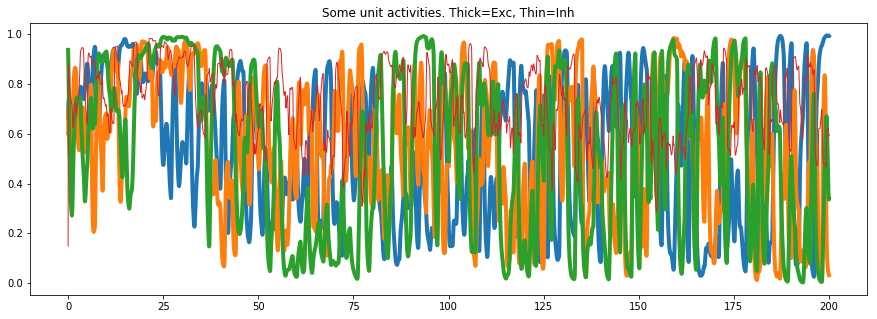

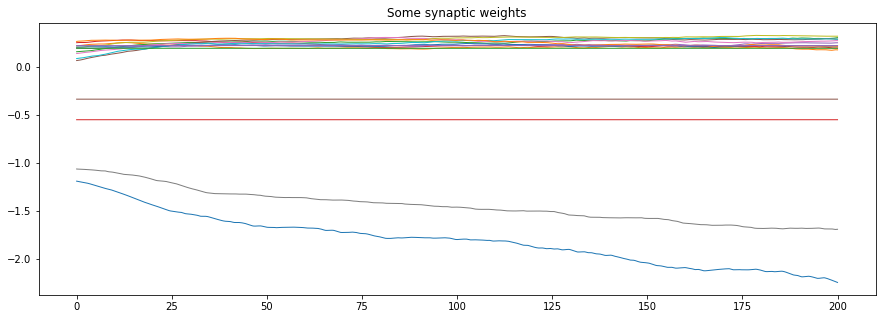

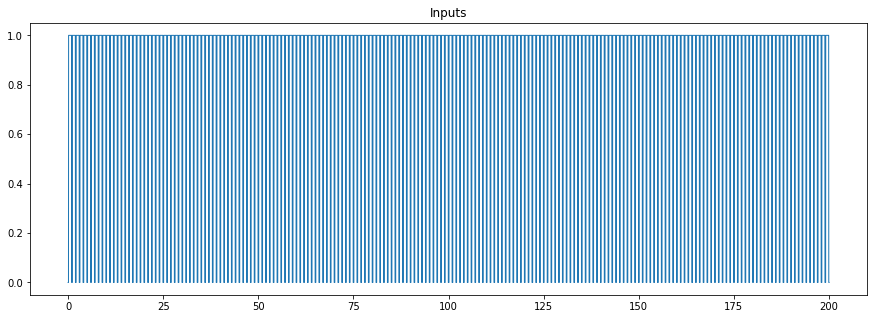

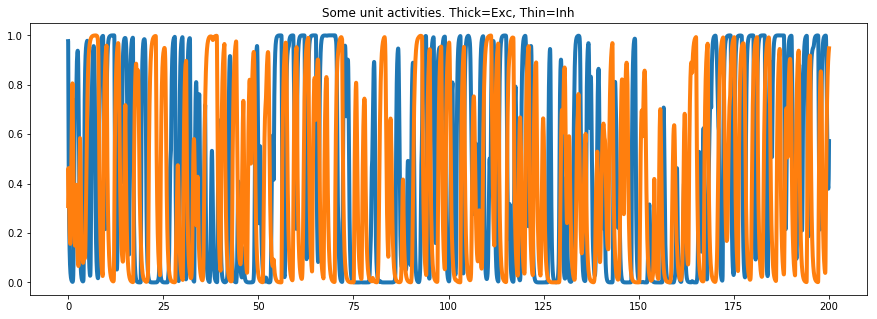

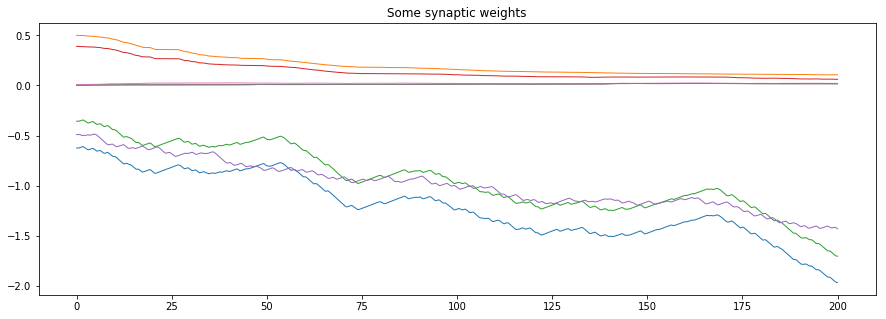

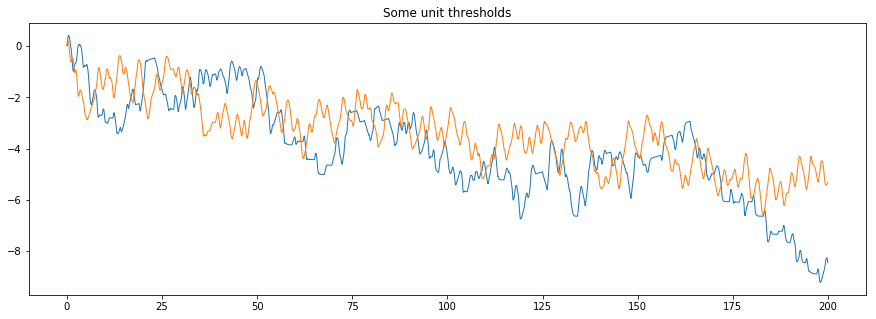

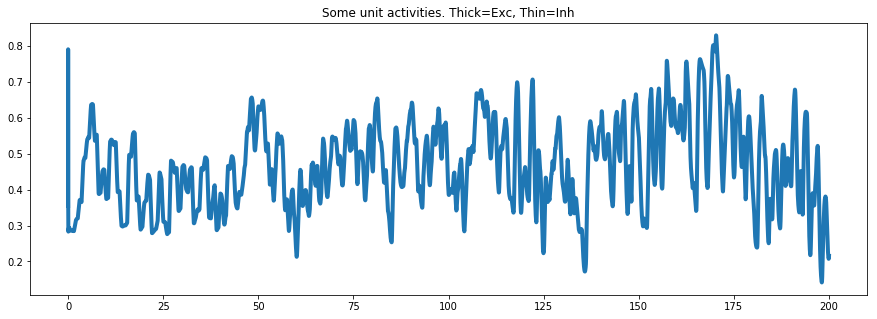

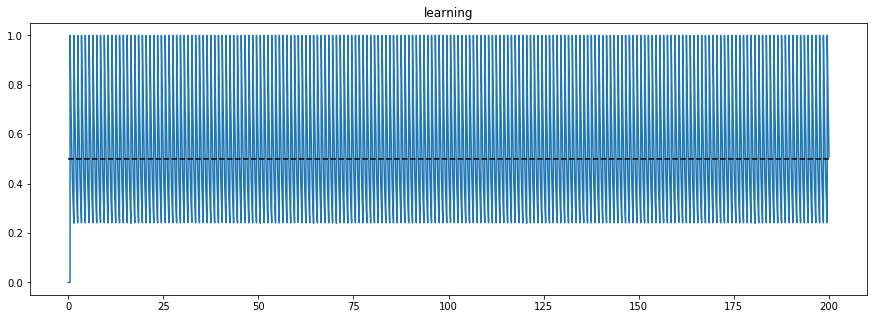

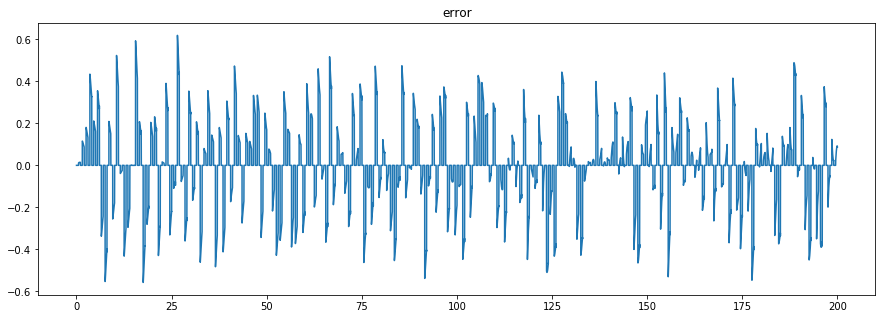

In [97]:
# basic plot 
%matplotlib inline
net_num = 4
net = s1p4_obj.nets[net_num]
L = net.layers['L']
LI3 = net.layers['LI3']
#shrp = net.layers['shrp']
I1 = net.layers['I1']
I2 = net.layers['I2']
I3 = net.layers['I3']
D = net.layers['D']
des = net.layers['des']
print(L.notes)
print(LI3.notes)
net.basic_plot('L')
net.basic_plot('LI3')
net.basic_plot('D')

norm of output matrix: 80.675601
norm of input matrix: 68.718427
norm of difference between matrices: 18.242027


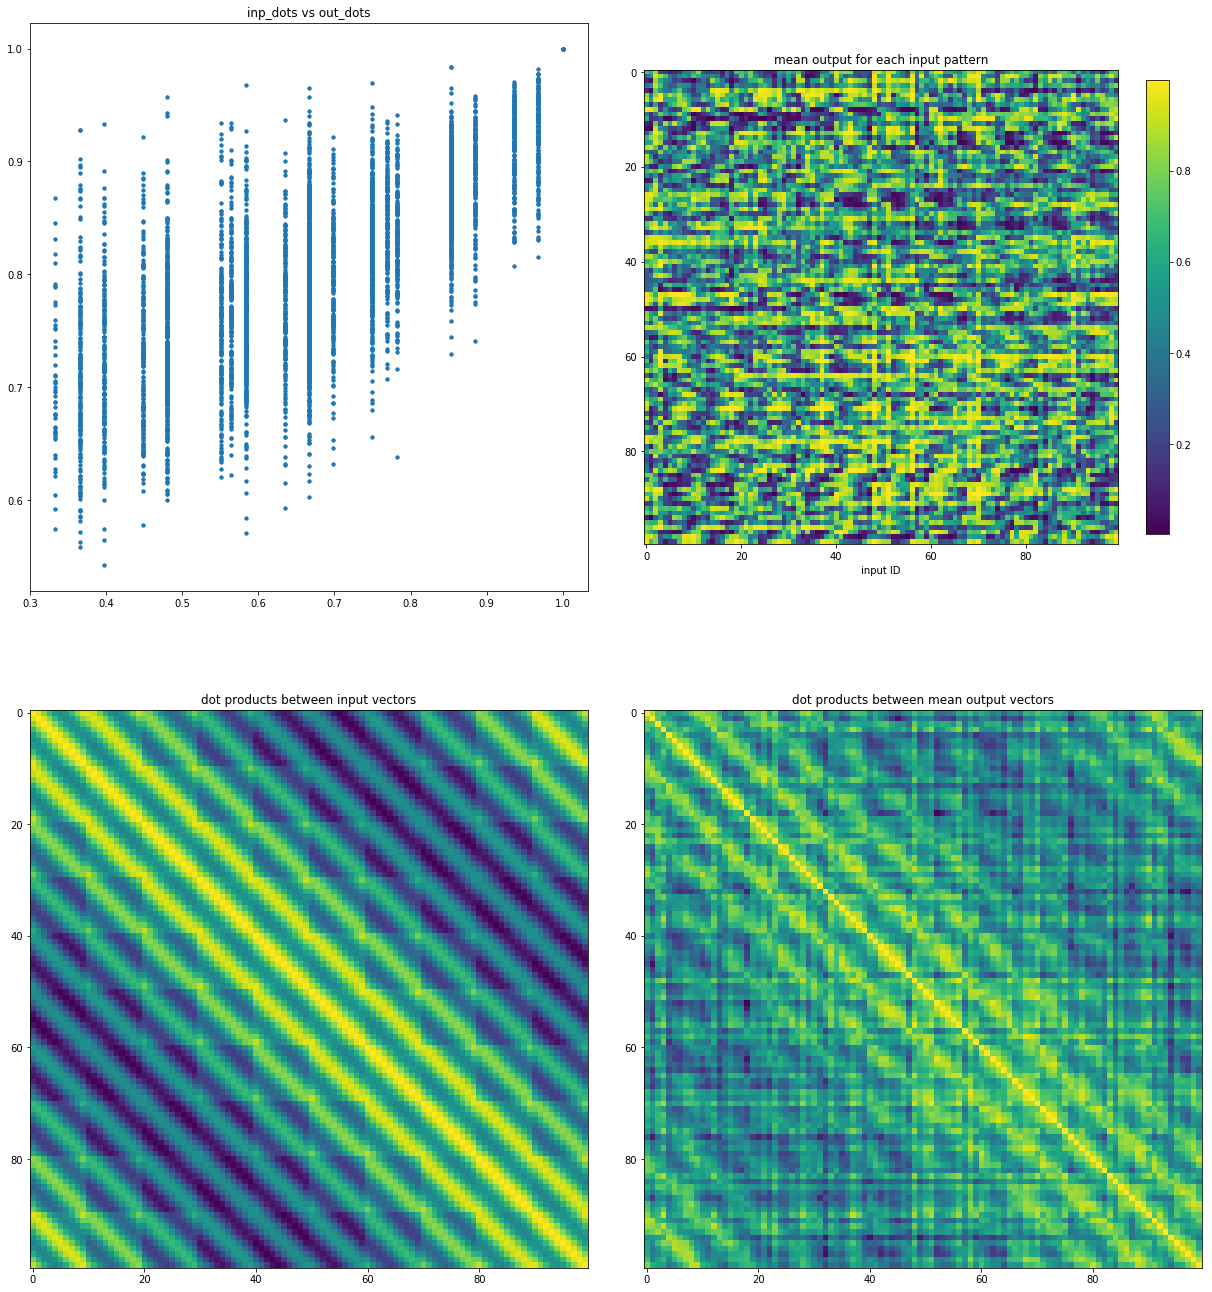

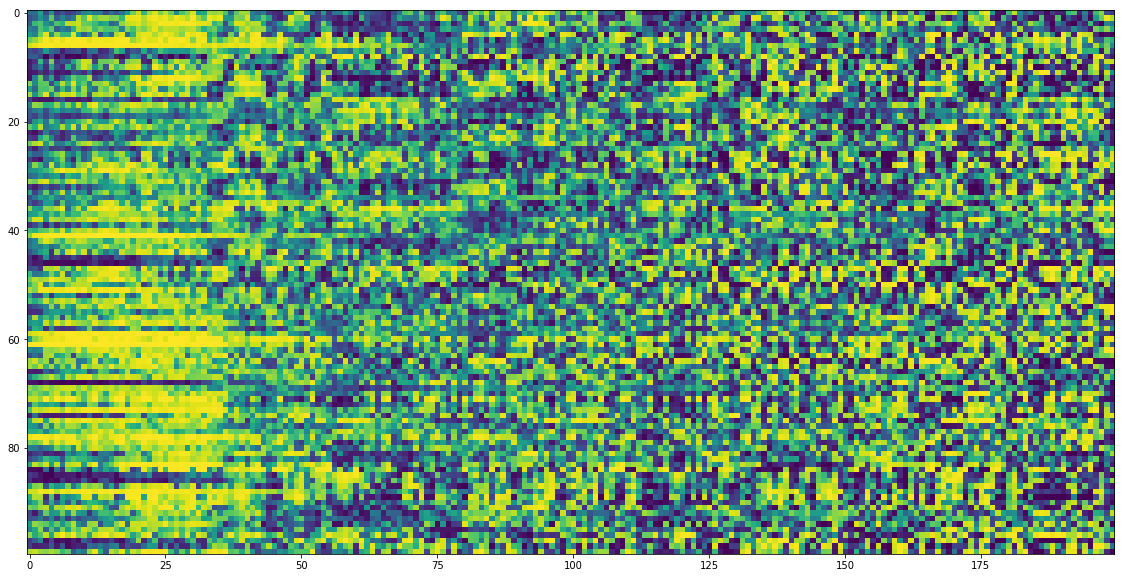

In [98]:
# input-output analysis for I1,2->L
#s1p4_obj.io_compare(net_num=net_num)
s1p4_obj.io_compare(net_num=net_num, make_history=True)

mean dot product is 0.836792, mean angle in degrees is 33.197079
mean norm of the difference: 1.030989, mean i3 norm: 1.918929, mean_li3 norm: 1.756542


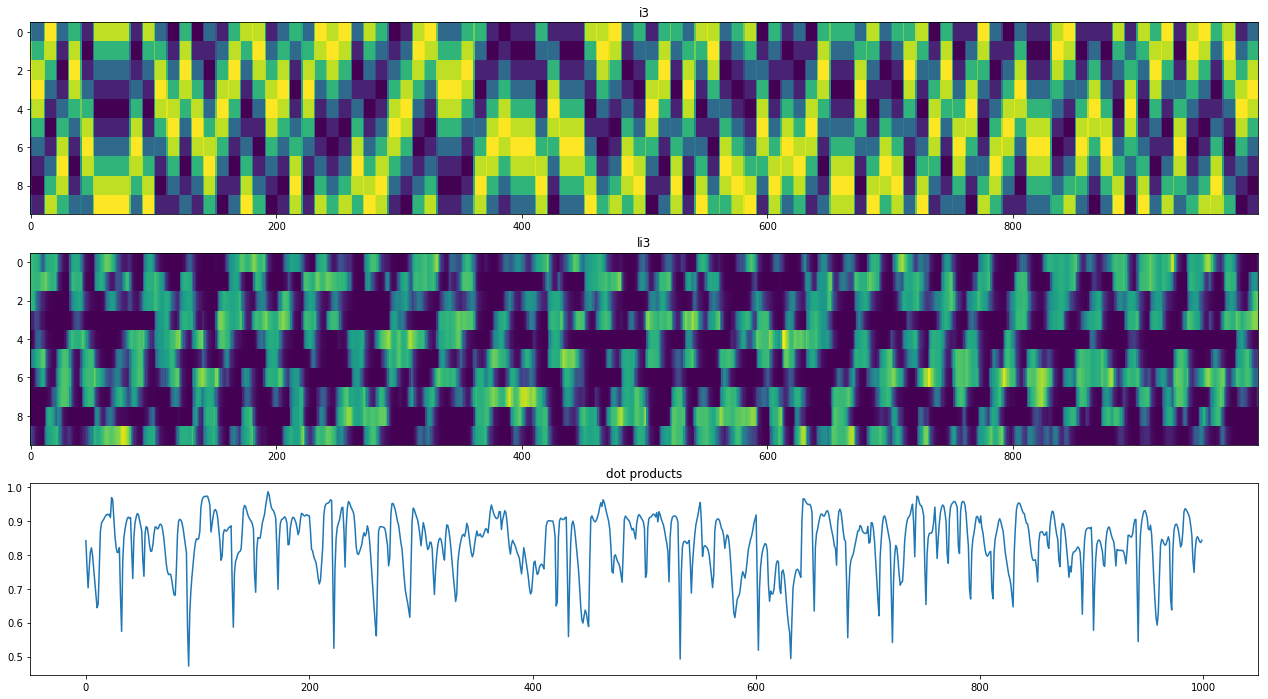

In [99]:
# input-output analysis for I3->LI3
#s1p4_obj.I3_LI3_compare(100., 20, net_num)
s1p4_obj.I3_LI3_compare(100., 20, net_num, make_history=True)

In [ ]:
# compare output of the delta unit with the desired output
start_t = 0.
middle_t = 10.
end_t = 20.
s1p4_ob.des_D_compare(start_t, middle_t, end_t, net_num=0 make_history=False)

norm of error in first part: 35.7009718006
s for desired value (first part): 37.6534569462
norm of error in second part: 31.7936749191
second moment for desired value (second part): 36.9446550863


Text(0.5,1,'error')

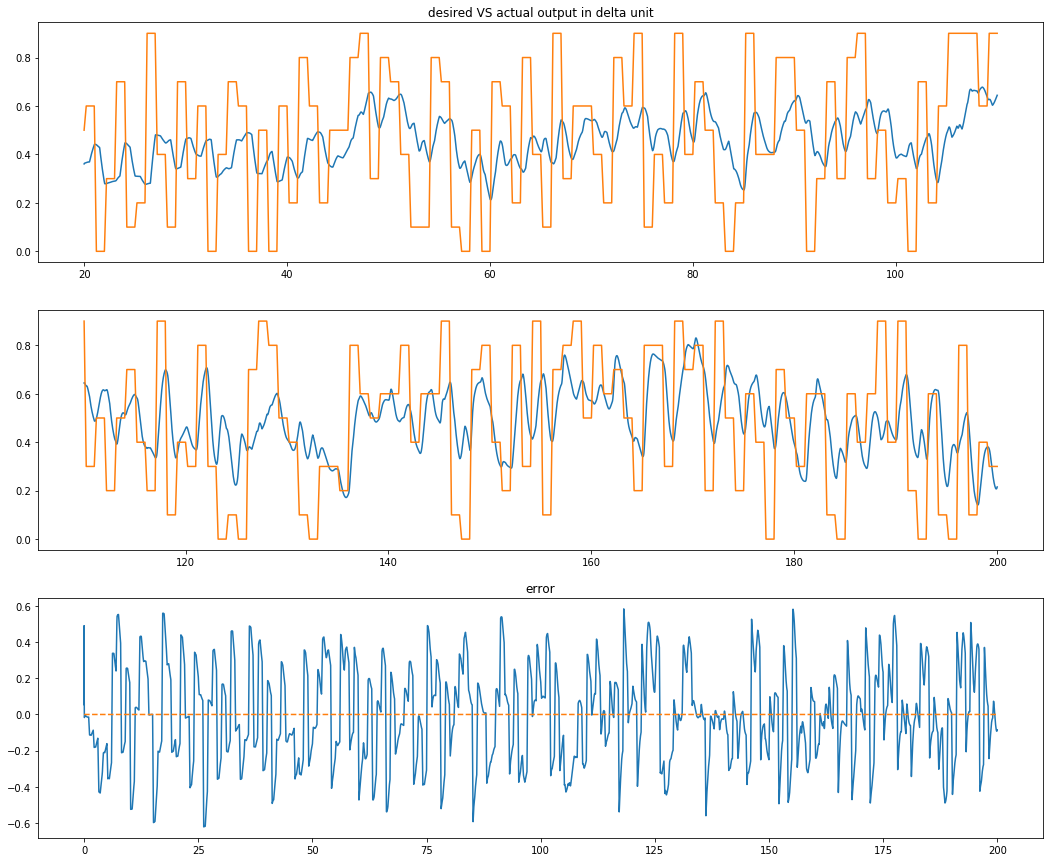

In [102]:
# DEPRECATED
# Compare the output of the delta unit with the desired output.
# This is done from start_t to middle_t, and then from middle_t to end_t, to see if things are improving.
# The norm of the difference between delta output and desired value is compared with the norm of the 
# difference between the desired value and its mean.
%matplotlib inline
start_t = 20.
middle_t = 110.
end_t = 200.
# change the
st_idx = int(np.floor(start_t / s1p4_obj.nets[net_num].net.min_delay))
mid_idx = int(np.floor(middle_t / s1p4_obj.nets[net_num].net.min_delay))
end_idx = int(np.floor(end_t / s1p4_obj.nets[net_num].net.min_delay))

times1 = net.all_times[st_idx:mid_idx]
delta1 = net.all_activs[D.e[0]][st_idx:mid_idx]
des1 = net.all_activs[des.x[0]][st_idx:mid_idx]
times2 = net.all_times[mid_idx:end_idx]
delta2 = net.all_activs[D.e[0]][mid_idx:end_idx]
des2 = net.all_activs[des.x[0]][mid_idx:end_idx]

cmp_fig, cmp_axes = plt.subplots(3,1, figsize=(18,15))
plt0 = cmp_axes[0].plot(times1, delta1, times1, des1) 
cmp_axes[0].set_title('desired VS actual output in delta unit')
plt1 = cmp_axes[1].plot(times2, delta2, times2, des2)

# compare norm of (delta-des) against standard deviation of des (norm of des - <des>)
# e.g. is delta better than a static value?
diff_vec1 = delta1 - des1
des_mean1 = np.mean(des1)
des_shift1 = des1 - des_mean1
norm_diff1 = np.linalg.norm(diff_vec1)
norm_shift1 = np.linalg.norm(des_shift1)
print("norm of error in first part: " + str(norm_diff1))
print("std dev for desired value (first part): " + str(norm_shift1))

diff_vec2 = delta2 - des2
des_mean2 = np.mean(des2)
des_shift2 = des2 - des_mean2
norm_diff2 = np.linalg.norm(diff_vec2)
norm_shift2 = np.linalg.norm(des_shift2)
print("norm of error in second part: " + str(norm_diff2))
print("std dev for desired value (second part): " + str(norm_shift2))

plt3 = cmp_axes[2].plot(net.all_times, net.all_activs[D.e[0]] - net.all_activs[des.x[0]], net.all_times, np.tile(0, (len(net.all_times), 1)), '--')
cmp_axes[2].set_title('error')


In [45]:
np.mean(np.array([1, 2, 3]))

2.0

In [111]:
#net.double_anim(L.e, slider=False, interv=10, nbins=20, thr=0.7, pdf=True)
net.double_anim(L.e+LI3.e+I1.x+I2.x+I3.x, slider=True, interv=10, nbins=20, thr=0.7, pdf=True)

interactive(children=(IntSlider(value=20000, description='frame', max=40000, min=1), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [35]:
net.all_activs[des.x[0]][63990]

IndexError: index 63990 is out of bounds for axis 0 with size 40000

In [ ]:
s1p4_obj.input_list[148:151]

[5 9 1 3 2 0]


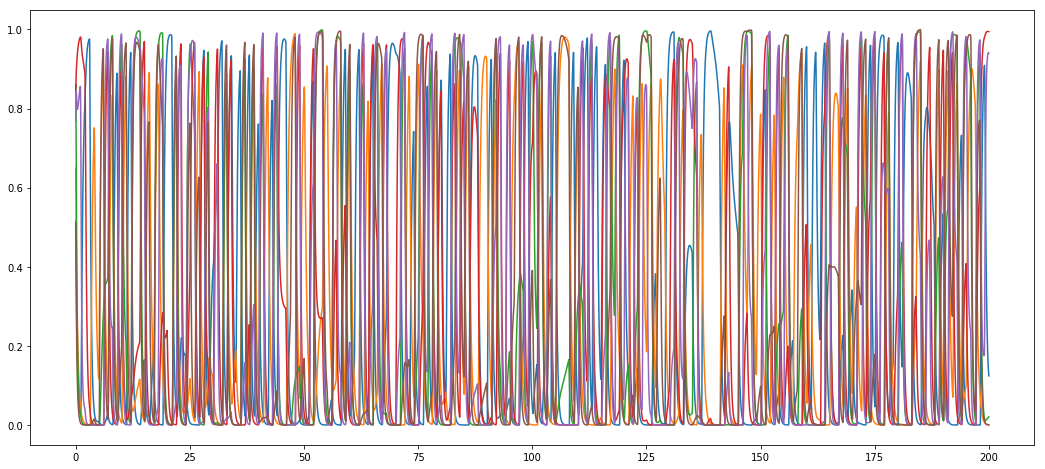

In [71]:
# Plot the highest excitatory unit activities (LI3)
%matplotlib inline
n_top = 6  # how many units to plot
top_pop = np.array(LI3.e)  # population to visualize
top_units = net.all_activs[top_pop].sum(1).argpartition(-n_top)[-n_top:]
print(top_units)
top_act_fig = plt.figure(figsize=(18,8))
top_acts = net.all_activs[top_pop[top_units]].transpose()
plt.plot(net.all_times, top_acts)
plt.show()

[64 37 17  6]


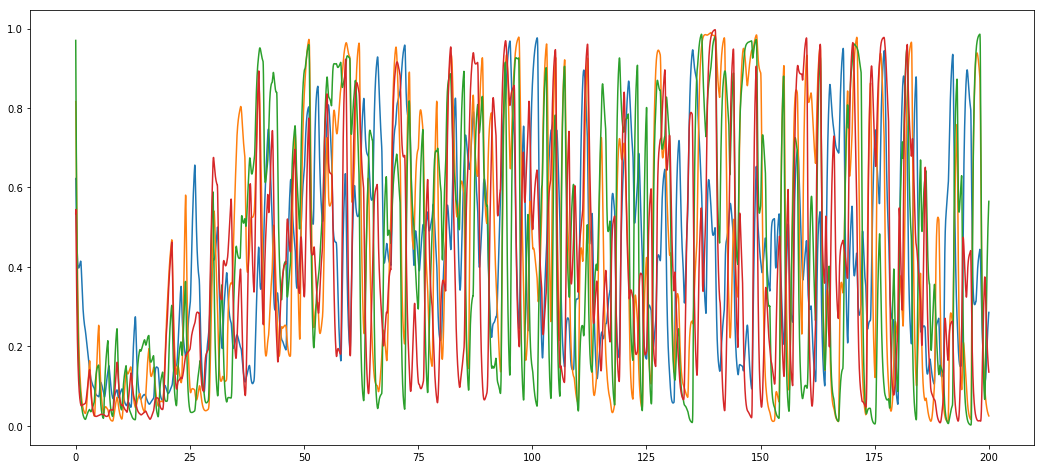

In [63]:
# Plot the lowest excitatory unit activities
n_bottom = 5  # how many units to plot
bottom_pop = np.array(L.e)  # population to visualize
bottom_units = net.all_activs[bottom_pop].sum(1).argpartition(n_bottom)[0:n_bottom-1]
print(bottom_units)
bottom_act_fig = plt.figure(figsize=(18,8))
bottom_acts = net.all_activs[bottom_pop[bottom_units]].transpose()
plt.plot(net.all_times, bottom_acts)
plt.show()

In [96]:
# Annotations for individual networks
net.annotate("Using sds_trdc units in LI3 makes the I3 representation worsen. The rdc mechanism makes some units")
net.annotate("stick to their previous values. The delta unit shows an improvement, although a bit less than with sds units.")
#net.annotate("than in I3 (the cosine has a wide peak).") 
#net.annotate("most responses are between 0.1 and 0.8 .")
#net.annotate("Did not look in detail, but it reminded me of multiplicative modulation.")
#net.annotate("with ei_runner_mp.", make_history=False)
#net.annotate("stop growing.", make_history=False)

In [95]:
net.notes

'# NOTE: This is network 3 in a run of an mp_net_runner object called s1p4mp_sig_test1\n# NOTE: Based on the step1p2_07-19-18.txt, trying to get a baseline configuration for sigmoidals, and\n# NOTE: for step1p4_mp.\n# NOTE: Network reloaded from pkl file.\n# NOTE: Network reloaded from pkl file.\n'

In [ ]:
# Visualize the connections
#ei_net.conn_anim(I1.x+I2.x, L.e, slider=False)
net.conn_anim(L.e, L.e, slider=False)

In [ ]:
# log all networks
s1p4_obj.log() 

In [ ]:
# saving
for net in s1p4_obj.nets:
    net.history.append('ei_net object being saved in container mp_ei_runner object ' + s1p4_obj.name)
F = open(s1p4_obj.name+'.pkl', 'wb')
dill.dump(s1p4_obj, F)
F.close()

In [ ]:
# loading
#F = open("/media/z/data/pickles/exp_dist_sig_test4.pkl", 'rb')
#F = open("/home/z/projects/draculab/sig_ssrdc_test1.pkl", 'rb')
F = open("/home/z/projects/draculab/sig_trdc_test1.pkl", 'rb')
mp_net_obj = dill.load(F)

In [ ]:
# Write the configuration of the mp_net_runner object in the simulation log
f = open(log_file, mode='a')
f.write(runner.stdout)
f.close()

In [ ]:
s1p4_obj.code = str(runner)

In [ ]:
# Continue running after loading
s1p4_obj.run_all(save=True, log=False, save_interv=10)

In [ ]:
print(s1p4_obj.code)

In [ ]:
# Continue running after loading
s1p4_obj.run_all(save=True, log=False, save_interv=10)

In [ ]:
# mean activity given the rate distribution
c = 3
a = np.exp(-c)
b = 1-a
mean = (b/c**3)*(1. - (c+1.)*a)
print(mean)

n_points = 1000
r = np.linspace(0.,1.,n_points)
pdf = (b/c)*np.exp(-c*r)
mean2 = np.dot(r,pdf)/n_points
print(mean2)

In [ ]:
for n in range(11):
    mp_net_obj.nets[n+1].log(log_file, False)

In [ ]:
log_file